# Exploratory Data Analysis

## Libraries and Dependencies

In [1]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import re
import os
import squarify
import warnings
import textstat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import base64
from io import BytesIO
from IPython.display import display, HTML, Image


warnings.filterwarnings("ignore")

In [3]:
# ============================ CONFIGURATION ==================================
DATA_PATH = '/kaggle/input/datasciencedata/job_descriptions.csv'
PLOT_STYLE = 'seaborn'  # Can choose from: 'seaborn', 'ggplot', 'fivethirtyeight'
plt.style.use(PLOT_STYLE)

In [4]:
df = pd.read_csv(DATA_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615940 entries, 0 to 1615939
Data columns (total 23 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Job Id            1615940 non-null  int64  
 1   Experience        1615940 non-null  object 
 2   Qualifications    1615940 non-null  object 
 3   Salary Range      1615940 non-null  object 
 4   location          1615940 non-null  object 
 5   Country           1615940 non-null  object 
 6   latitude          1615940 non-null  float64
 7   longitude         1615940 non-null  float64
 8   Work Type         1615940 non-null  object 
 9   Company Size      1615940 non-null  int64  
 10  Job Posting Date  1615940 non-null  object 
 11  Preference        1615940 non-null  object 
 12  Contact Person    1615940 non-null  object 
 13  Contact           1615940 non-null  object 
 14  Job Title         1615940 non-null  object 
 15  Role              1615940 non-null  object 
 16  

# Omdeh Visualizations

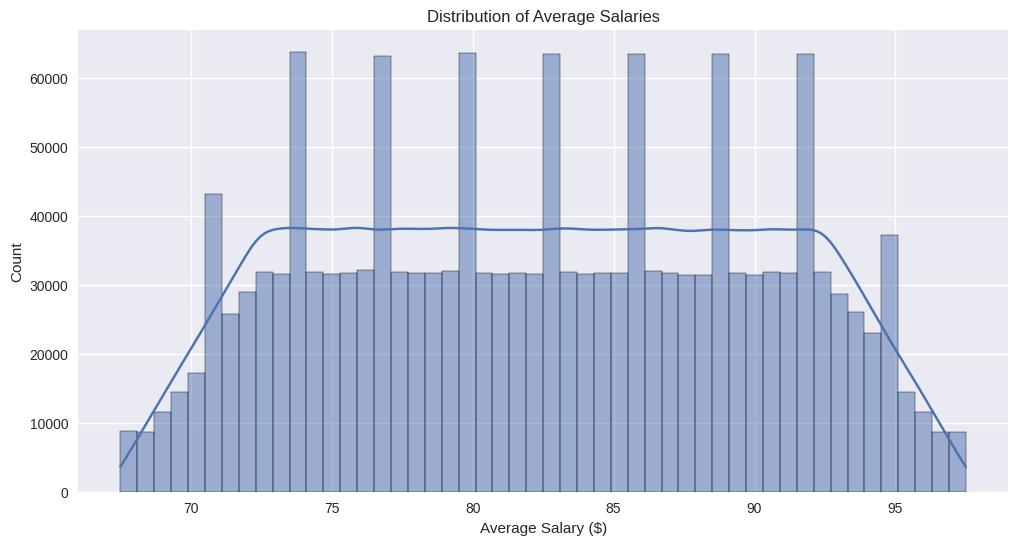

In [5]:
#@title Salary Range Distribution
import re

def extract_salary(salary_str):
    # Find all numeric values in the string
    numbers = re.findall(r'\$?(\d{1,3}(?:,\d{3})*)', salary_str)
    if len(numbers) >= 2:
        try:
            low = float(numbers[0].replace(',', ''))
            high = float(numbers[1].replace(',', ''))
            return (low + high) / 2  # Return average
        except:
            return None
    return None

df['salary_avg'] = df['Salary Range'].apply(extract_salary)

# Plot distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['salary_avg'].dropna(), bins=50, kde=True)
plt.title('Distribution of Average Salaries')
plt.xlabel('Average Salary ($)')
plt.ylabel('Count')
plt.show()

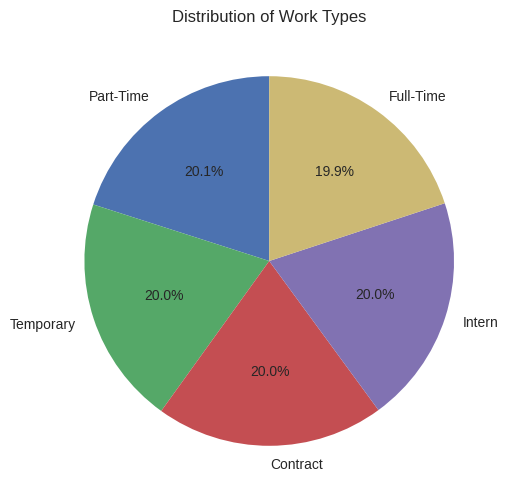

In [6]:
#@title Work Type 

work_type_counts = df['Work Type'].value_counts()

plt.figure(figsize=(10, 6))
work_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Work Types')
plt.ylabel('')
plt.show()

In [7]:
pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
import networkx as nx
from pyvis.network import Network

# Create role-skills bipartite graph
G = nx.Graph()

# Add nodes and edges (sample for performance)
for _, row in df.sample(10000).iterrows():
    role = row['Role']
    skills = [s.strip() for s in row['skills'].split(',')]
    
    G.add_node(role, type='role')
    for skill in skills[:10]:  # Limit skills per role
        G.add_node(skill, type='skill')
        G.add_edge(role, skill)

# Visualize with pyvis
net = Network(notebook=True, width="1000px", height="700px", bgcolor="#222222", font_color="white")
net.from_nx(G)
net.show("roles_skills_network.html")

roles_skills_network.html


In [9]:
import plotly.express as px

fig = px.scatter_3d(
    df.sample(5000),  # Sample for performance
    x='longitude',
    y='latitude',
    z='salary_avg',
    color='Experience',
    hover_name='Job Title',
    hover_data=['Company', 'skills'],  # Changed from 'Skills' to 'skills'
    title='Geospatial Salary Distribution by Experience',
    height=700
)

# Customize the view
fig.update_traces(marker=dict(size=4))
fig.update_layout(scene=dict(
    zaxis_title='Salary ($)',
    xaxis_title='Longitude',
    yaxis_title='Latitude'
))
fig.show()

## UTILITY FUNCTIONS

In [10]:
STOPWORDS = {
    'a', 'an', 'the', 'and', 'or', 'but', 'to', 'of', 'in', 'on', 'at', 'for', 
    'with', 'by', 'as', 'into', 'from', 'is', 'are', 'was', 'were', 'it', 'that',
    'this', 'these', 'those', 'be', 'have', 'has', 'had', 'do', 'does', 'did',
    'will', 'would', 'should', 'can', 'could', 'may', 'might', 'must', 'i', 'you',
    'he', 'she', 'we', 'they', 'their', 'our', 'your', 'my'
}

def text_analyzer(text_series, top_n=20, min_word_length=1):
    text_series = text_series.fillna('').astype(str)

    # Basic stats
    lengths = text_series.str.len()
    word_counts = text_series.str.split().str.len()

    results = {
        'length_stats': {
            'mean': lengths.mean(),
            'max': lengths.max(),
            'min': lengths.min(),
            'median': lengths.median()
        },
        'word_count_stats': {
            'mean': word_counts.mean(),
            'max': word_counts.max(),
            'min': word_counts.min(),
            'median': word_counts.median()
        }
    }

    # Readability scores (skipped when -> short/single-token data)
    if 'textstat' in globals():
        try:
            if word_counts.mean() >= 5:
                readability = text_series.apply(
                    lambda x: textstat.flesch_reading_ease(x) if x.strip() else np.nan
                )
                results['readability'] = {
                    'mean': readability.mean(),
                    'median': readability.median(),
                    'score_interpretation': 'Higher = easier to read (90-100: Very Easy, 60-70: Standard)'
                }
        except Exception as e:
            print(f"⚠️ Readability analysis skipped: {str(e)}")

    # Frequency of Word/token 
    all_text = ' '.join(text_series).lower()

    # if possible -> use words, too sparse -> fallback to tokens
    words = re.findall(rf'\b[a-z]{{{min_word_length},}}\b', all_text)
    if not words:  # fallback if regex fails
        words = all_text.split()

    filtered_words = [word.strip() for word in words if word and word not in STOPWORDS]
    results['top_words'] = Counter(filtered_words).most_common(top_n)

    return results

def label_style_analyzer(text_series, top_n=20):
    text_series = text_series.fillna('').astype(str)
    tokens = text_series.str.lower().str.strip().tolist()

    flat = []
    for entry in tokens:
        parts = re.split(r'[\s,\|;/\-]+', entry)
        flat.extend([p for p in parts if p and p not in STOPWORDS])

    top_tokens = Counter(flat).most_common(top_n)
    return {
        'token_count': len(flat),
        'unique_tokens': len(set(flat)),
        'top_tokens': top_tokens
    }

def plot_to_html(fig, filename="plot.png", add_download_button=True):
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
    buf.seek(0)
    img_bytes = buf.read()
    img_str = base64.b64encode(img_bytes).decode('utf-8')
    plt.close(fig)

    html = f'<img src="data:image/png;base64,{img_str}" style="max-width:100%;">'

    if add_download_button:
        html += f"""
        <div style="margin-top: 8px;">
            <a download="{filename}" href="data:image/png;base64,{img_str}" 
               style="background-color: darkslateblue; color: white; padding: 6px 12px; border-radius: 4px; 
                      text-decoration: none; font-weight: bold; font-family: Arial;">
               ⬇️ Download PNG
            </a>
        </div>
        """

    return html

def plot_geospatial(data, lat_col='latitude', lon_col='longitude'):
    plt.figure(figsize=(12, 8))
    
    # base plot
    plot = sns.scatterplot(
        data=data,
        x=lon_col,
        y=lat_col,
        alpha=0.6,
        hue='Company Size' if 'Company Size' in data.columns else None,
        size='Company Size' if 'Company Size' in data.columns else None,
        palette='coolwarm'
    )
    
    # titles and labels
    plt.title('Geospatial Distribution of Job Listings', fontsize=14, pad=20)
    plt.xlabel('Longitude', labelpad=10)
    plt.ylabel('Latitude', labelpad=10)
    
    # grid and adjust legend
    plt.grid(True, alpha=0.3)
    if 'Company Size' in data.columns:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

## 🔄 Data Loading & Initial Validation

In [11]:
display(HTML("""
<div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
    <h2 style="color: white; font-weight: bold;">🔄 Data Loading & Initial Validation</h2>
</div>
"""))

try:
    # Loading the first 10% of the data
    df = pd.read_csv(DATA_PATH, nrows=170000)
    
    # column types
    NUM_COLS = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    TEXT_COLS = df.select_dtypes(include=['object', 'string']).columns.tolist()
    OTHER_COLS = [col for col in df.columns if col not in NUM_COLS and col not in TEXT_COLS]
    
    # validation card
    validation_html = f"""
    <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
        <div style="display: flex; align-items: center; margin-bottom: 15px;">
            <span style="font-size: 24px; margin-right: 10px;">✅</span>
            <h3 style="color: white; font-weight: bold; margin: 0;">Data Successfully Loaded</h3>
        </div>
        
        <div style="display: flex; flex-wrap: wrap; gap: 15px; margin-bottom: 15px;">
            <div style="flex: 1; min-width: 200px; background: #3a3a3a; padding: 15px; border-radius: 6px;">
                <p style="color: #a0a0a0; margin: 0 0 5px 0; font-size: 0.9em;">Sample Shape</p>
                <p style="color: white; font-size: 1.2em; margin: 0; font-weight: bold;">{df.shape[0]} rows × {df.shape[1]} cols</p>
            </div>
            
            <div style="flex: 1; min-width: 200px; background: #3a3a3a; padding: 15px; border-radius: 6px;">
                <p style="color: #a0a0a0; margin: 0 0 5px 0; font-size: 0.9em;">Numeric Columns</p>
                <p style="color: white; font-size: 1.2em; margin: 0; font-weight: bold;">{len(NUM_COLS)}</p>
            </div>
            
            <div style="flex: 1; min-width: 200px; background: #3a3a3a; padding: 15px; border-radius: 6px;">
                <p style="color: #a0a0a0; margin: 0 0 5px 0; font-size: 0.9em;">Text Columns</p>
                <p style="color: white; font-size: 1.2em; margin: 0; font-weight: bold;">{len(TEXT_COLS)}</p>
            </div>
        </div>
    """
    
    # Adding column type breakdown IF there are other types
    if OTHER_COLS:
        validation_html += f"""
        <div style="background: #3a3a3a; padding: 15px; border-radius: 6px; margin-bottom: 15px;">
            <p style="color: #FF9800; margin: 0 0 10px 0; font-weight: bold;">⚠️ Other Column Types Found</p>
            <p style="color: white; margin: 0;">Columns: {', '.join(OTHER_COLS)}</p>
        </div>
        """
    
    # close card
    validation_html += "</div>"
    
    display(HTML(validation_html))
    
    # Initial validation
    if df.empty:
        raise ValueError("Dataset is empty")
        
except Exception as e:
    error_html = f"""
    <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
        <div style="display: flex; align-items: center; margin-bottom: 15px;">
            <span style="font-size: 24px; margin-right: 10px;">❌</span>
            <h3 style="color: #FF5252; font-weight: bold; margin: 0;">Data Loading Failed</h3>
        </div>
        <div style="background: #3a3a3a; padding: 15px; border-radius: 6px;">
            <p style="color: white; margin: 0;">Error: {str(e)}</p>
        </div>
    </div>
    """
    display(HTML(error_html))
    raise

## 🔍 DATA QUALITY ASSESSMENT

In [12]:
display(HTML("""
<div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
    <h2 style="color: white; font-weight: bold;">🔍 Data Quality Assessment</h2>
</div>
"""))

# 1st) Data Types & Completeness
buffer = io.StringIO()
df.info(verbose=True, buf=buffer, show_counts=True)
info_text = buffer.getvalue().replace('\n', '<br>').replace(' ', '&nbsp;')

display(HTML(f"""
<div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
    <h3 style="color: white; font-weight: bold;">📌 Data Types & Completeness</h3>
    <div style="background: #1a1a1a; padding: 15px; border-radius: 6px; overflow-x: auto;">
        <pre style="color: #e0e0e0; margin: 0; font-family: monospace; white-space: pre-wrap;">{info_text}</pre>
    </div>
    <p style="color: #a0a0a0; margin-top: 10px; font-size: 0.9em;">Total entries: {len(df)} | Columns: {len(df.columns)}</p>
</div>
"""))

# 2nd) Missing Values Analysis 
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_percent.round(2),
    'Data Type': df.dtypes
}).sort_values(by='Missing %', ascending=False)

missing_df_styled = missing_df[missing_df['Missing Count'] > 0].style \
    .background_gradient(subset=['Missing %'], cmap='Oranges') \
    .format({'Missing %': "{:.2f}%"}) \
    .set_properties(**{
        'background-color': '#2a2a2a',
        'color': 'white',
        'border-color': '#3a3a3a'
    })

if missing_df[missing_df['Missing Count'] > 0].empty:
    missing_content = """
    <div style="background: #1a1a1a; padding: 15px; border-radius: 6px; text-align: center;">
        <p style="color: #4CAF50; font-weight: bold;">✅ No missing values found in any columns</p>
    </div>
    """
else:
    missing_content = missing_df_styled.to_html()

display(HTML(f"""
<div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
    <h3 style="color: white; font-weight: bold;">❗ Missing Values Analysis</h3>
    {missing_content}
</div>
"""))

# 3rd) Duplicate Analysis
duplicates = df.duplicated().sum()
dup_percent = duplicates/len(df)*100

if duplicates > 0:
    dup_sample = df[df.duplicated(keep=False)] \
        .sort_values(by=df.columns.tolist()) \
        .head(5) \
        .style \
        .set_properties(**{
            'background-color': '#2a2a2a',
            'color': 'white',
            'border-color': '#3a3a3a'
        })
    dup_content = f"""
    <div style="margin-top: 10px;">
        <p style="color: #FF9800; font-weight: bold;">⚠️ Found {duplicates} duplicate rows ({dup_percent:.2f}%)</p>
        <h4 style="color: white; margin-top: 15px;">Sample duplicate rows:</h4>
        {dup_sample.to_html()}
    </div>
    """
else:
    dup_content = """
    <div style="background: #1a1a1a; padding: 15px; border-radius: 6px; text-align: center;">
        <p style="color: #4CAF50; font-weight: bold;">✅ No duplicate rows found</p>
    </div>
    """

display(HTML(f"""
<div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
    <h3 style="color: white; font-weight: bold;">🔎 Duplicate Rows Analysis</h3>
    {dup_content}
</div>
"""))

## 📊 NUMERICAL FEATURE ANALYSIS


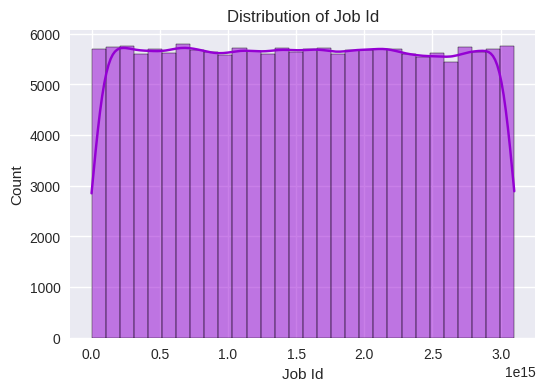
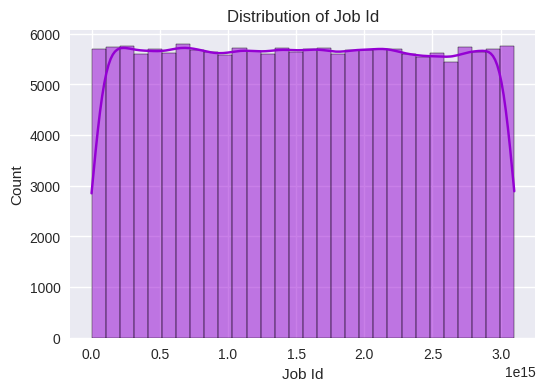
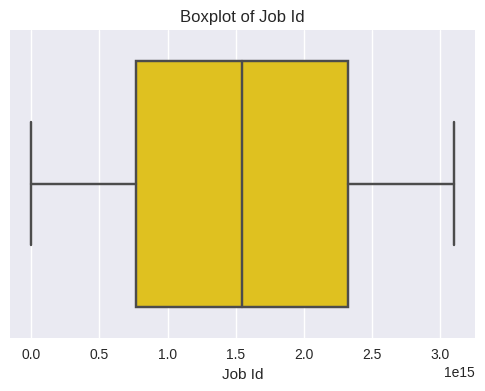
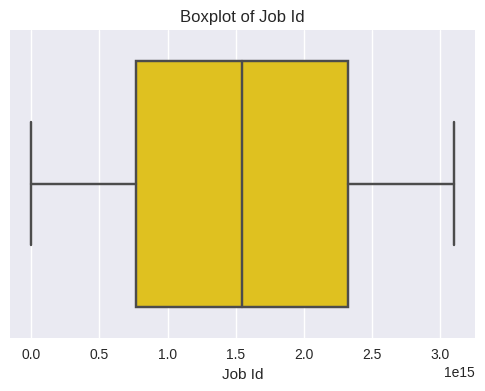


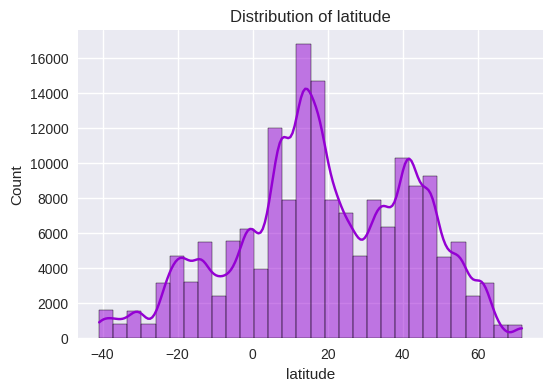
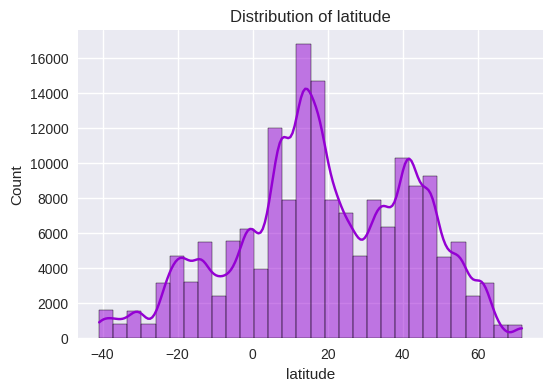
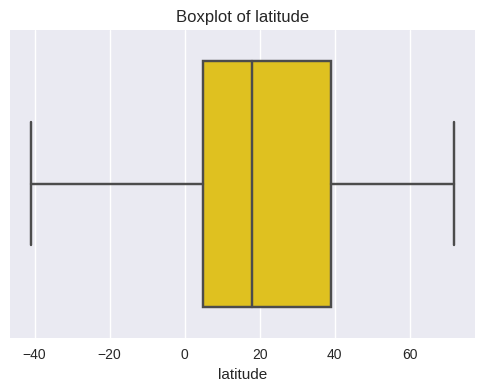
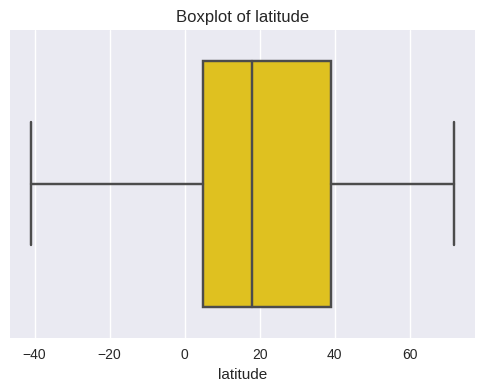


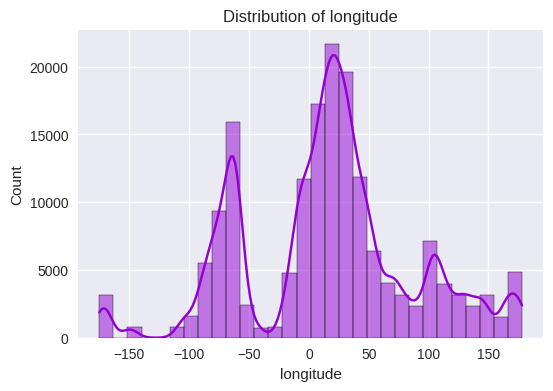
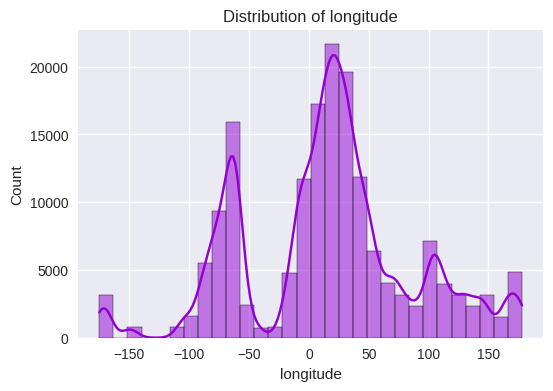
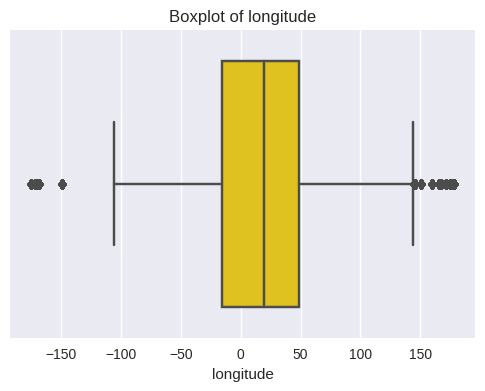
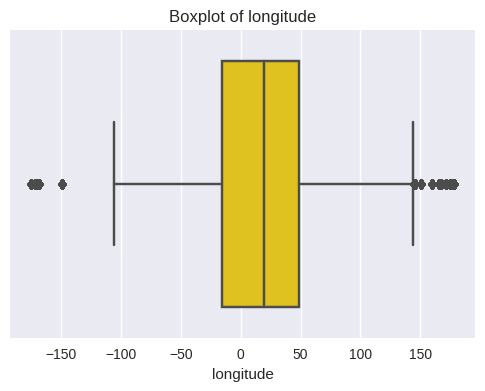


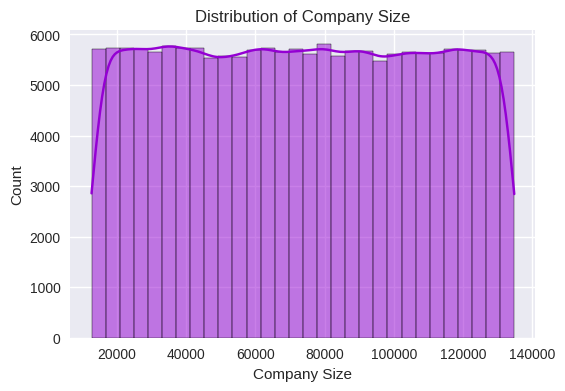
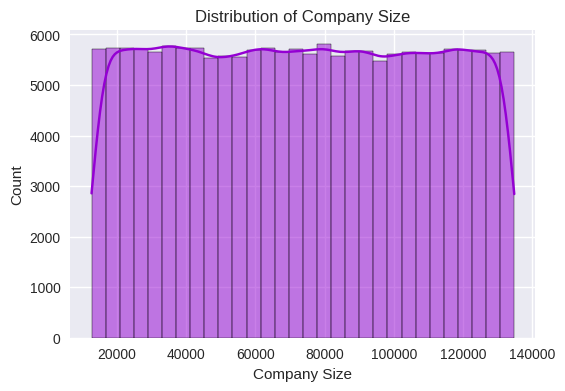
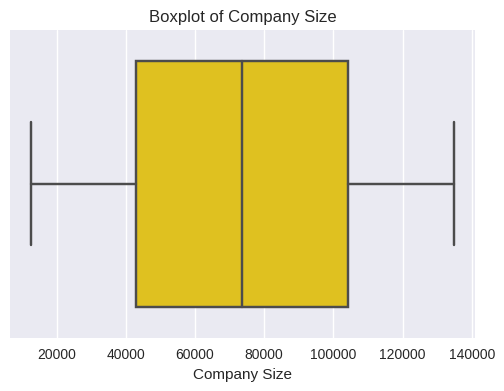
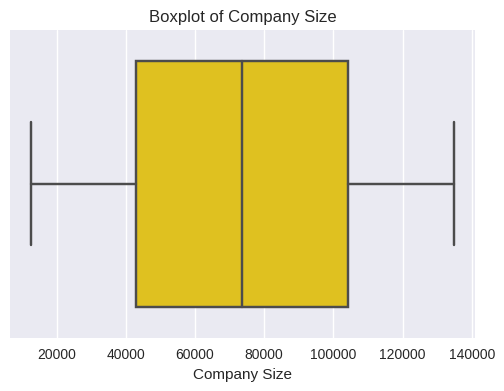


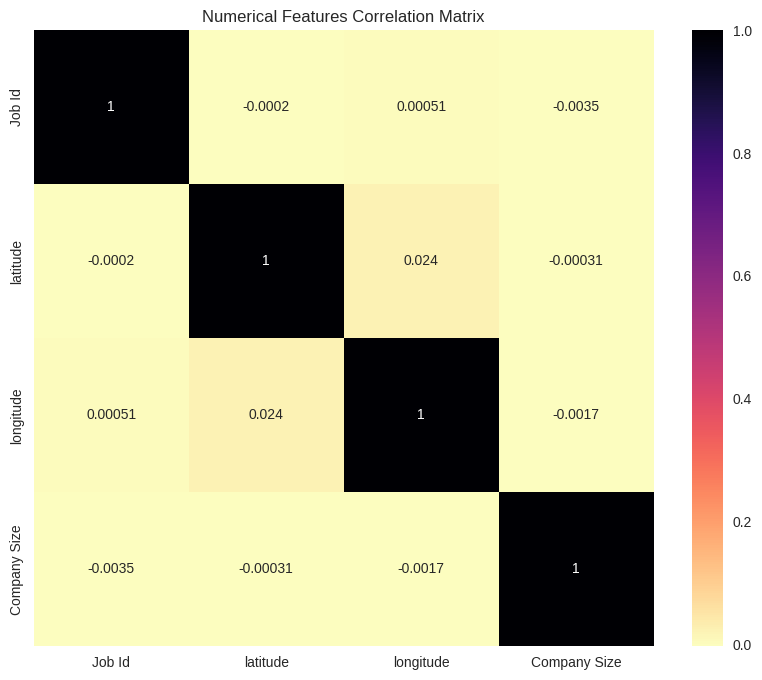
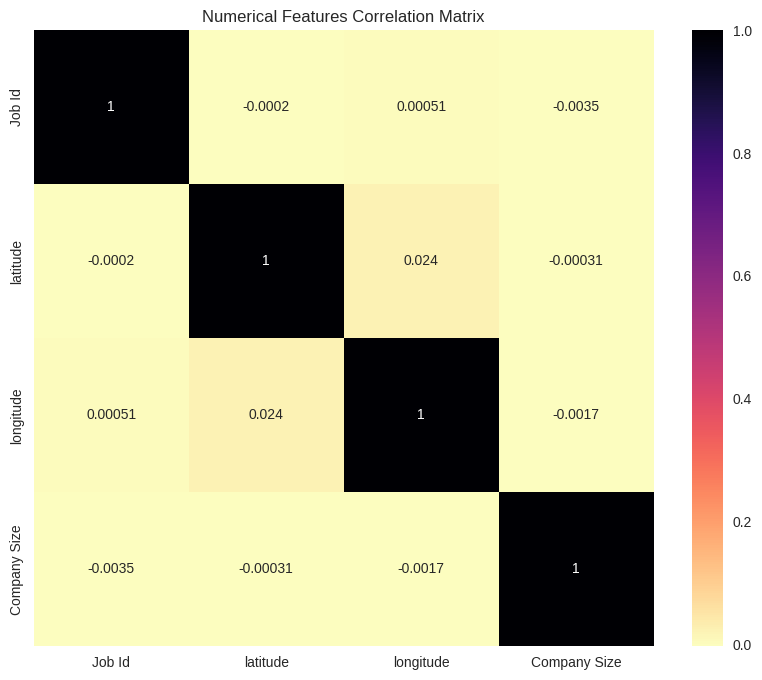

In [13]:
def display_numerical_analysis(df, num_cols):
    
    if not num_cols:
        display(HTML("<div style='color: orange;'>⚠️ No numerical columns found for analysis</div>"))
        return

    # Descriptive statistics
    num_stats = df[num_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
    num_stats['skewness'] = df[num_cols].skew()
    num_stats['kurtosis'] = df[num_cols].kurt()

    styled_table = num_stats.style.set_table_styles([
        {'selector': 'th', 'props': [('background', 'darkslateblue'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('font-weight', 'bold')]}
    ]).format(precision=2)

    display(HTML("""
        <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
            <h2 style="color: white; font-weight: bold;">📐 Summary Statistics for Numerical Features</h2>
        </div>
    """))
    display(styled_table)

    # Per-column visualizations
    for col in num_cols:
        # Histogram
        fig1, ax1 = plt.subplots(figsize=(6, 4))
        sns.histplot(df[col].dropna(), kde=True, bins=30, color="darkviolet", ax=ax1)
        ax1.set_title(f'Distribution of {col}')
        hist_img = plot_to_html(fig1, filename=f"{col}_hist.png")

        # Boxplot
        fig2, ax2 = plt.subplots(figsize=(6, 4))
        sns.boxplot(x=df[col], color="gold", ax=ax2)
        ax2.set_title(f'Boxplot of {col}')
        box_img = plot_to_html(fig2, filename=f"{col}_boxplot.png")

        # HTML layout
        html = f"""
        <div style="font-family: Arial; margin: 20px 0;">
            <h3 style="color: white; font-weight: bold;">📊 Feature: <span style="color:#4a8bc9;">{col}</span></h3>
            <div style="display: flex; flex-wrap: wrap; gap: 20px;">
                <div style="flex: 1; min-width: 300px; background: #2a2a2a; padding: 15px; border-radius: 8px;">
                    <h4 style="color: #FFFFFF;">🔹 Histogram</h4>
                    {hist_img}
                </div>
                <div style="flex: 1; min-width: 300px; background: #2a2a2a; padding: 15px; border-radius: 8px;">
                    <h4 style="color: #FFFFFF;">🔹 Boxplot</h4>
                    {box_img}
                </div>
            </div>
        </div>
        """
        display(HTML(html))

    # Correlation heatmap
    if len(num_cols) > 1:
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(df[num_cols].corr(), annot=True, cmap='magma_r', center=0.5, ax=ax)
        ax.set_title('Numerical Features Correlation Matrix')
        corr_img = plot_to_html(fig, filename="correlation_matrix.png")

        html = f"""
        <div style="font-family: Arial; margin: 30px 0; background: #2a2a2a; padding: 20px; border-radius: 10px;">
            <h2 style="color: white; font-weight: bold;">🔗 Correlation Matrix</h2>
            {corr_img}
        </div>
        """
        display(HTML(html))

display_numerical_analysis(df, NUM_COLS)

## 🏷️ CATEGORICAL (Label Style) & 📖 TEXTUAL (Rich Text) DATA ANALYSIS

In [14]:
def display_column_analysis(col, analysis): # for textual (rich-text) columns
    html = f"""
    <div style="font-family: Arial; margin-bottom: 20px; border-left: 4px solid #4a8bc9; padding-left: 10px;">
        <h2 style="color: #FFFFFF;">🔎 ANALYSIS FOR RICH-TEXT COLUMN: {col.upper()}</h2>
        
        <div style="margin-top: 15px; background: #2a2a2a; padding: 10px; border-radius: 5px;">
            <h3 style="color: #FFFFFF; margin-top: 0; font-weight: bold;">📏 Length Statistics (characters)</h3>
            {pd.DataFrame(analysis['length_stats'], index=[col]).style
                .set_table_styles([
                    {'selector': 'th', 'props': [('background', 'darkslateblue'), ('color', 'white'), ('font-weight', 'bold')]},
                    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('font-weight', 'bold')]}
                ])
                .format(precision=2)
                .to_html()}
        </div>
        
        <div style="margin-top: 15px; background: #2a2a2a; padding: 10px; border-radius: 5px;">
            <h3 style="color: #FFFFFF; margin-top: 0; font-weight: bold;">📊 Word Count Statistics</h3>
            {pd.DataFrame(analysis['word_count_stats'], index=[col]).style
                .set_table_styles([
                    {'selector': 'th', 'props': [('background', 'darkslateblue'), ('color', 'white'), ('font-weight', 'bold')]},
                    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('font-weight', 'bold')]}
                ])
                .format(precision=2)
                .to_html()}
        </div>
    """
    
    if 'readability' in analysis:
        html += f"""
        <div style="margin-top: 15px; background: #2a2a2a; padding: 10px; border-radius: 5px;">
            <h3 style="color: #FFFFFF; margin-top: 0; font-weight: bold;">📖 Readability Scores</h3>
            {pd.DataFrame(analysis['readability'], index=[col]).style
                .set_table_styles([
                    {'selector': 'th', 'props': [('background', 'darkslateblue'), ('color', 'white'), ('font-weight', 'bold')]},
                    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('font-weight', 'bold')]}
                ])
                .format(precision=2)
                .to_html()}
        </div>
        """
    
    html += f"""
        <div style="margin-top: 15px; background: #2a2a2a; padding: 10px; border-radius: 5px;">
            <h3 style="color: #FFFFFF; margin-top: 0; font-weight: bold;">🏆 Top {len(analysis['top_words'])} Words</h3>
            {pd.DataFrame(analysis['top_words'], columns=['Word', 'Count']).style
                .set_table_styles([
                    {'selector': 'th', 'props': [('background', 'darkslateblue'), ('color', 'white'), ('font-weight', 'bold')]},
                    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('font-weight', 'bold')]}
                ])
                .bar(subset=['Count'], color='darkslateblue')
                .to_html()}
        </div>
    </div>
    """
    
    display(HTML(html))

# ____________________________________________________________________________________

def display_label_card(col, result): # for categorical (label style) columns
    html = f"""
    <div style="font-family: Arial; margin: 20px 0; border-left: 4px solid #4a8bc9; padding-left: 10px;">
        <h2 style="color: white;">🏷️ ANALYSIS FOR LABEL-STYLE COLUMN: {col.upper()}</h2>

        <div style="margin-top: 15px; background: #2a2a2a; padding: 15px; border-radius: 8px;">
            <h3 style="color: #FFFFFF; font-weight: bold;">🔢 Token Summary</h3>
            <ul style="color: white; font-weight: bold;">
                <li>Total Tokens: {result['token_count']}</li>
                <li>Unique Tokens: {result['unique_tokens']}</li>
            </ul>
        </div>

        <div style="margin-top: 15px; background: #2a2a2a; padding: 15px; border-radius: 8px;">
            <h3 style="color: #FFFFFF; font-weight: bold;">🏆 Top {len(result['top_tokens'])} Tokens</h3>
            {pd.DataFrame(result['top_tokens'], columns=['Token', 'Count']).style
                .set_table_styles([
                    {'selector': 'th', 'props': [('background', 'darkslateblue'), ('color', 'white'), ('font-weight', 'bold')]},
                    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('font-weight', 'bold')]}
                ])
                .bar(subset=['Count'], color='darkslateblue')
                .to_html()}
        </div>
    </div>
    """
    display(HTML(html))


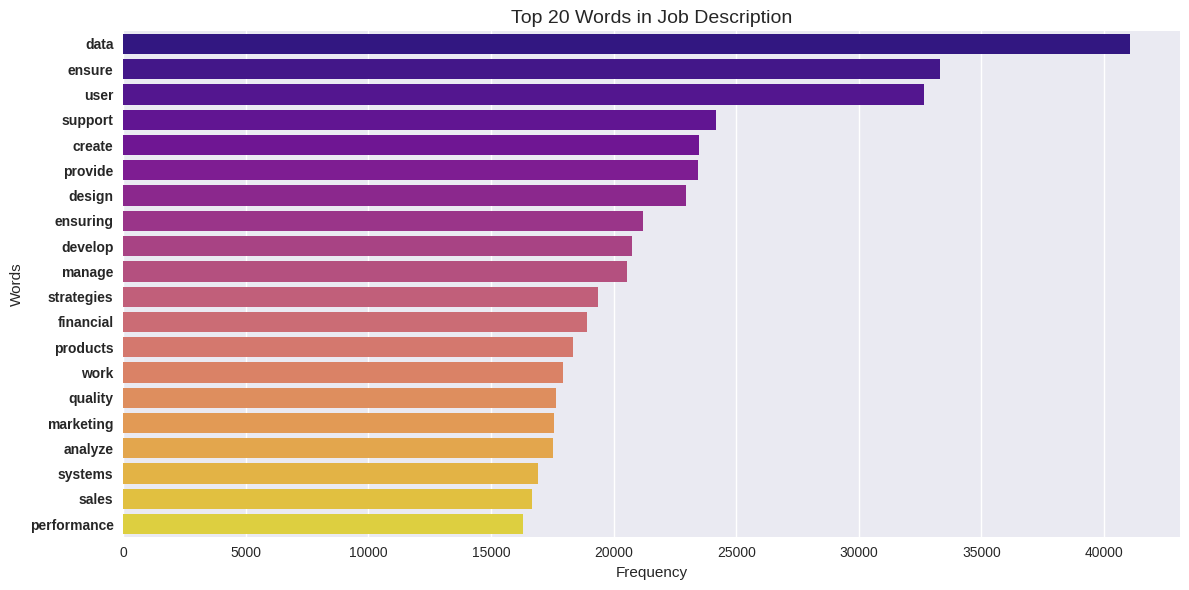
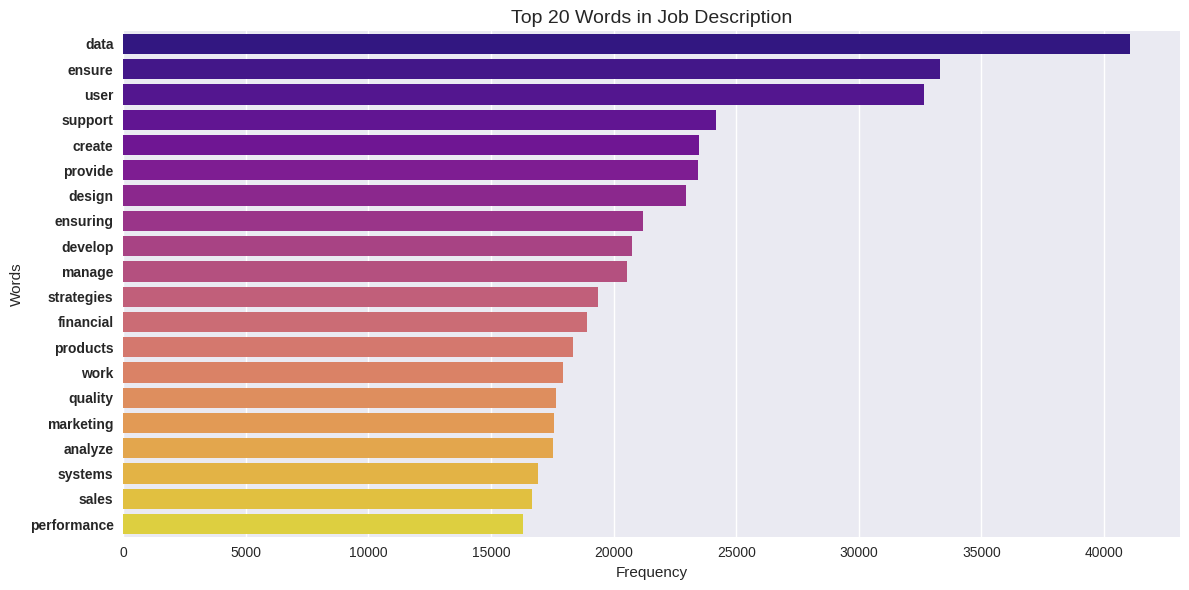
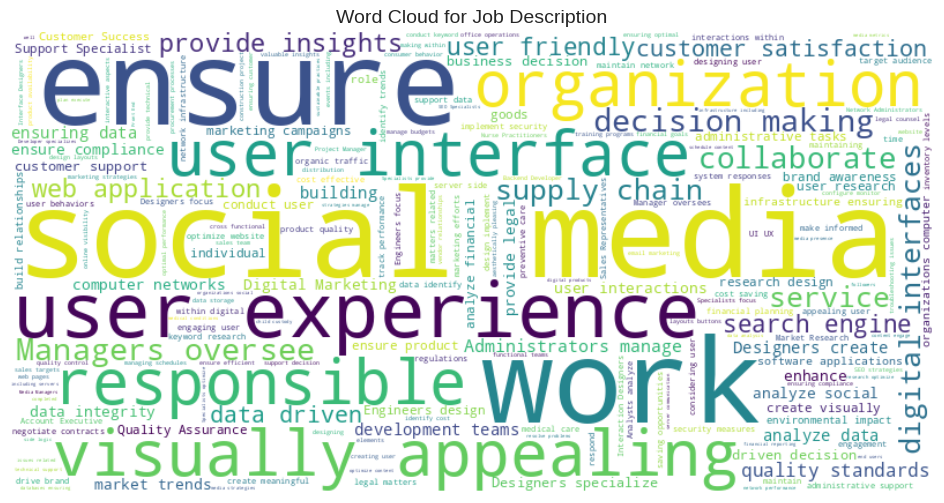
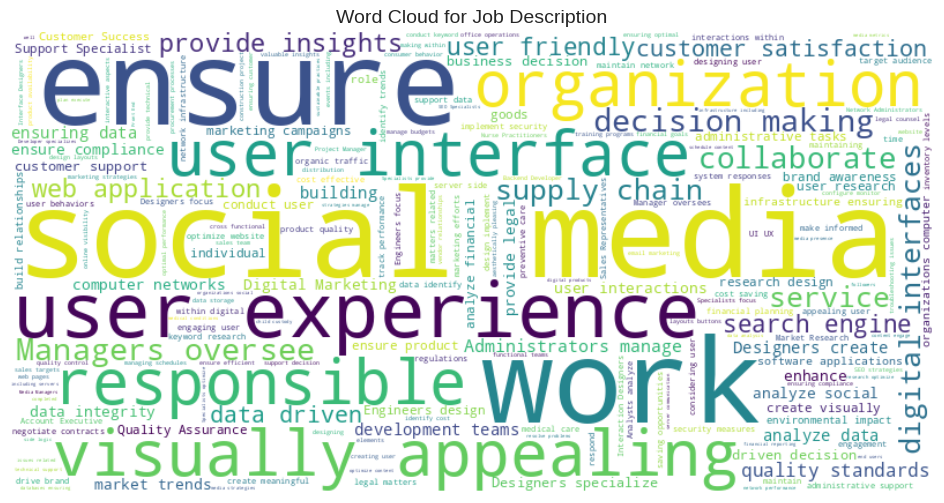


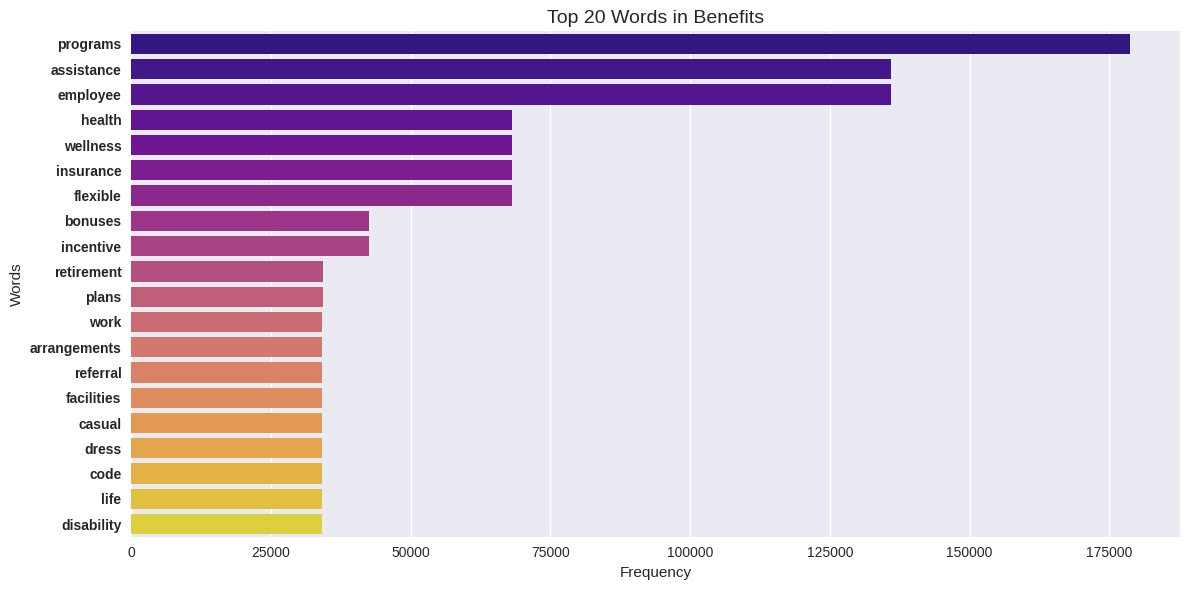
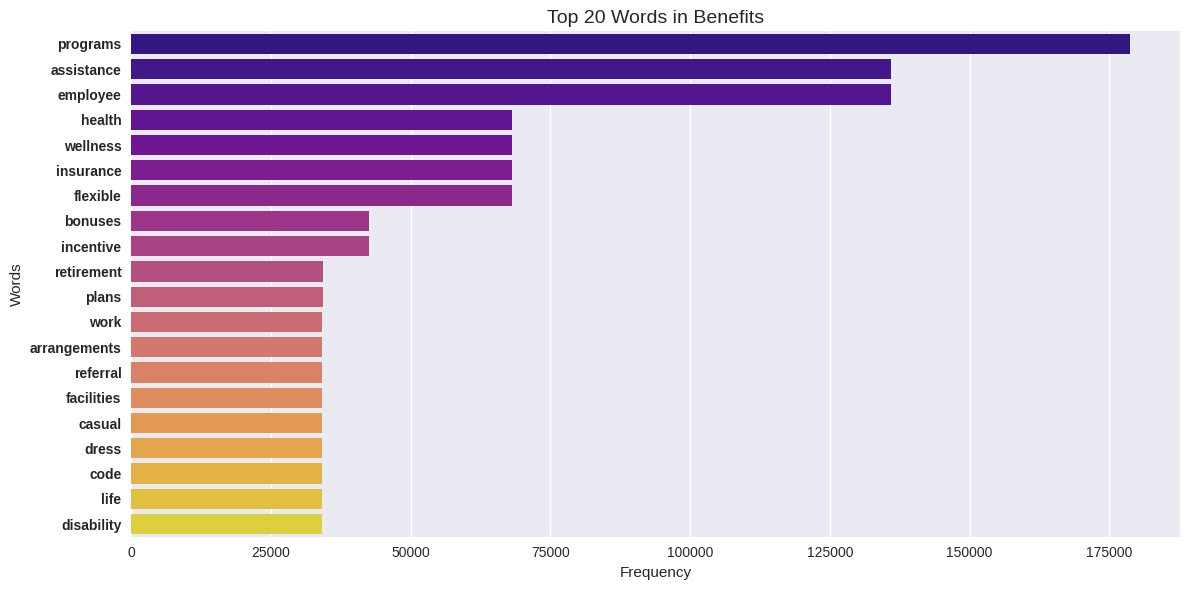
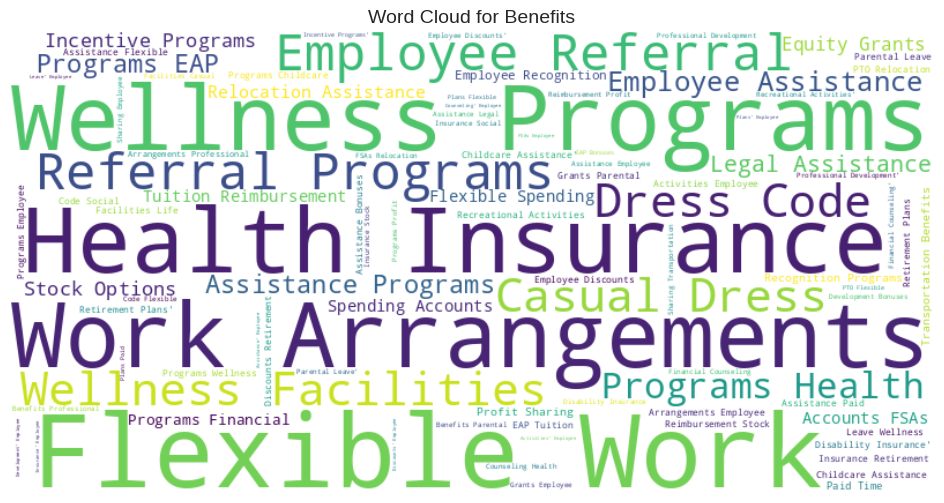
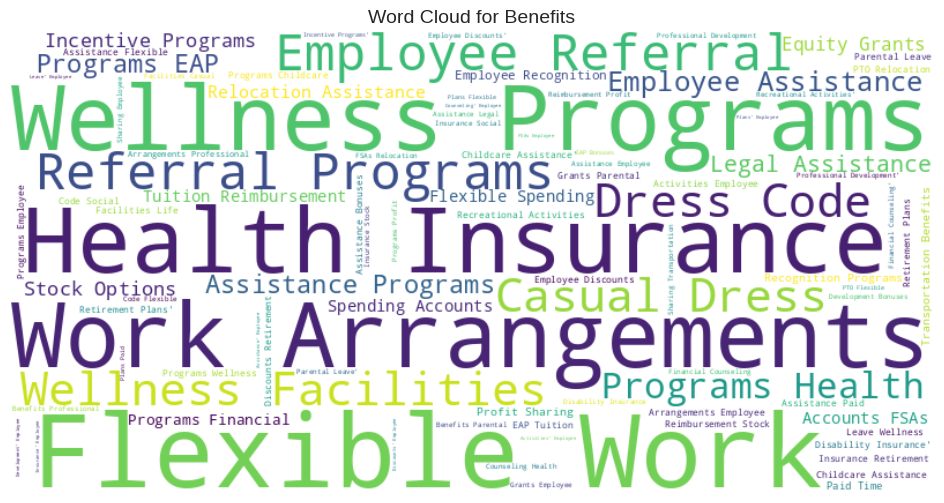


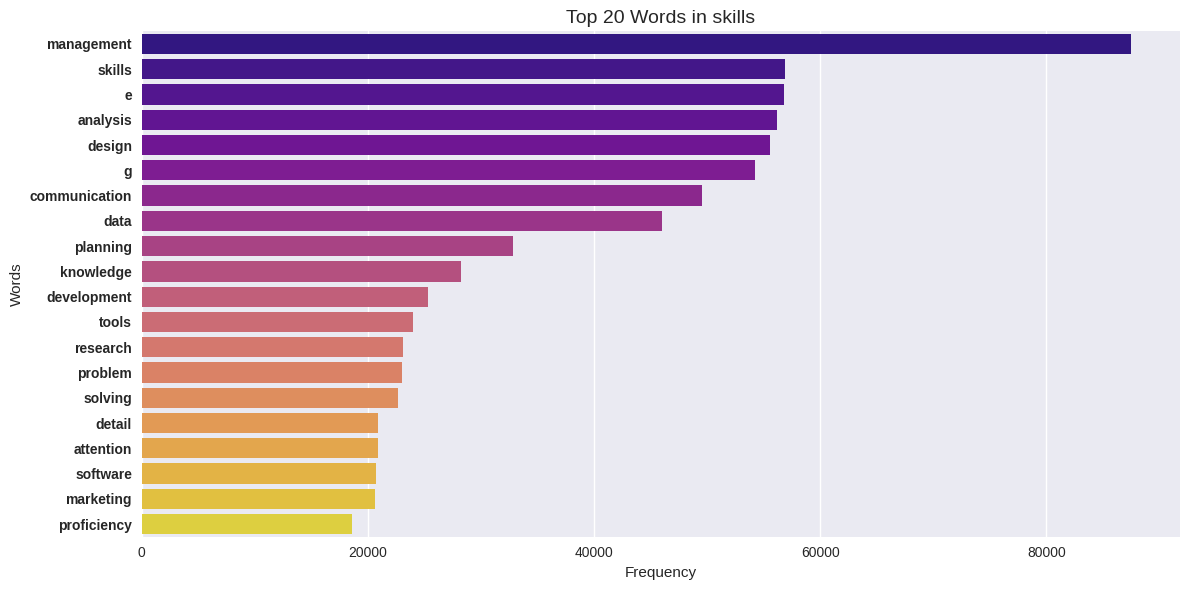
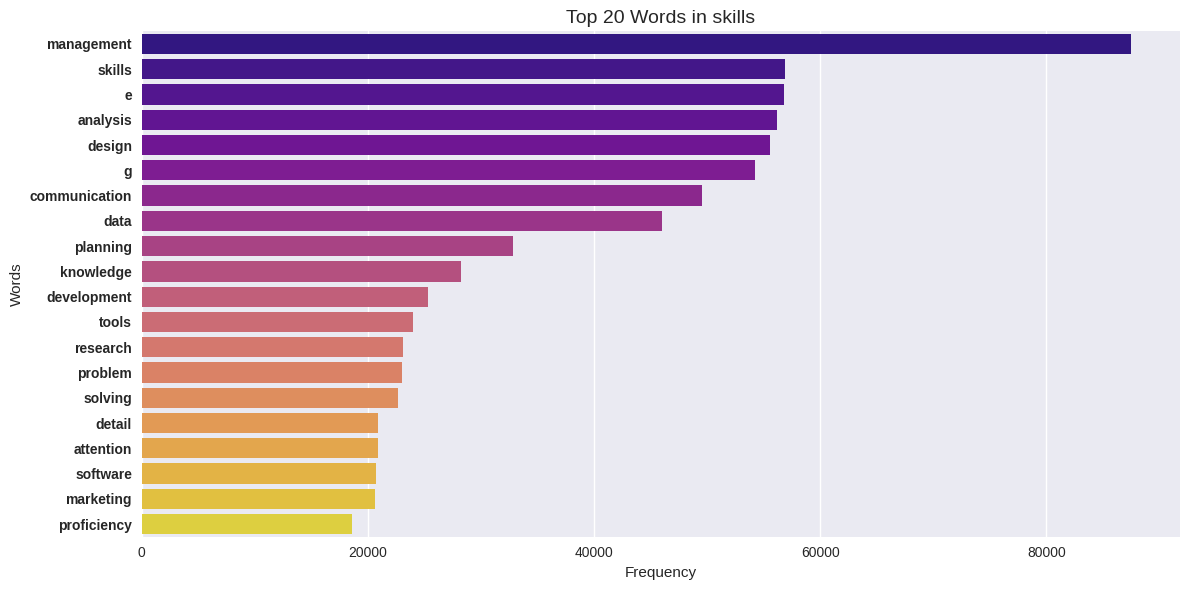
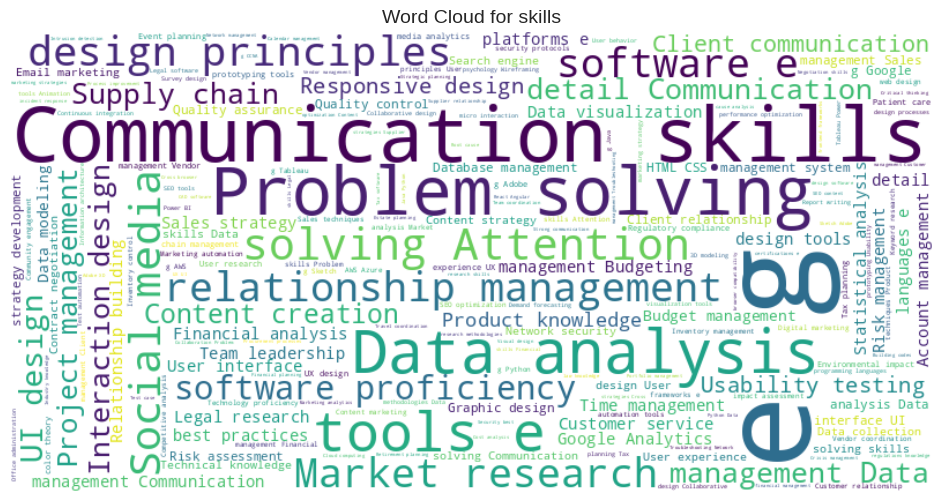
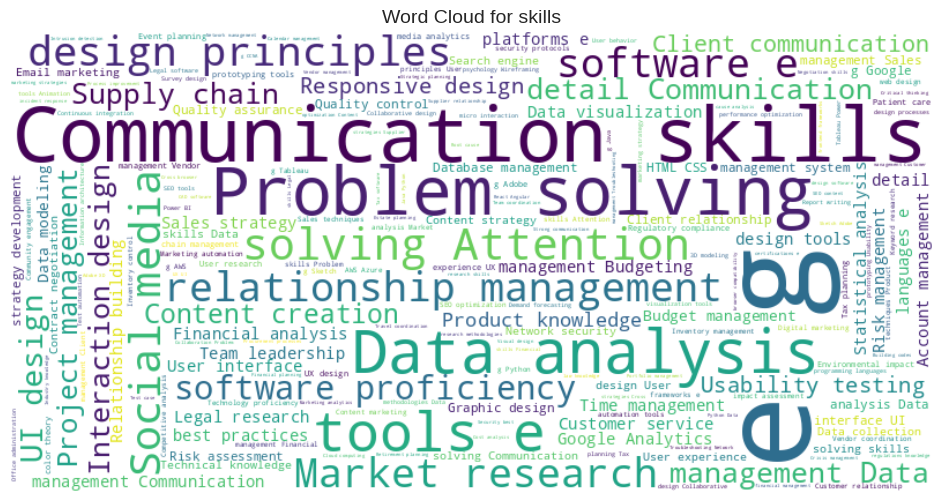


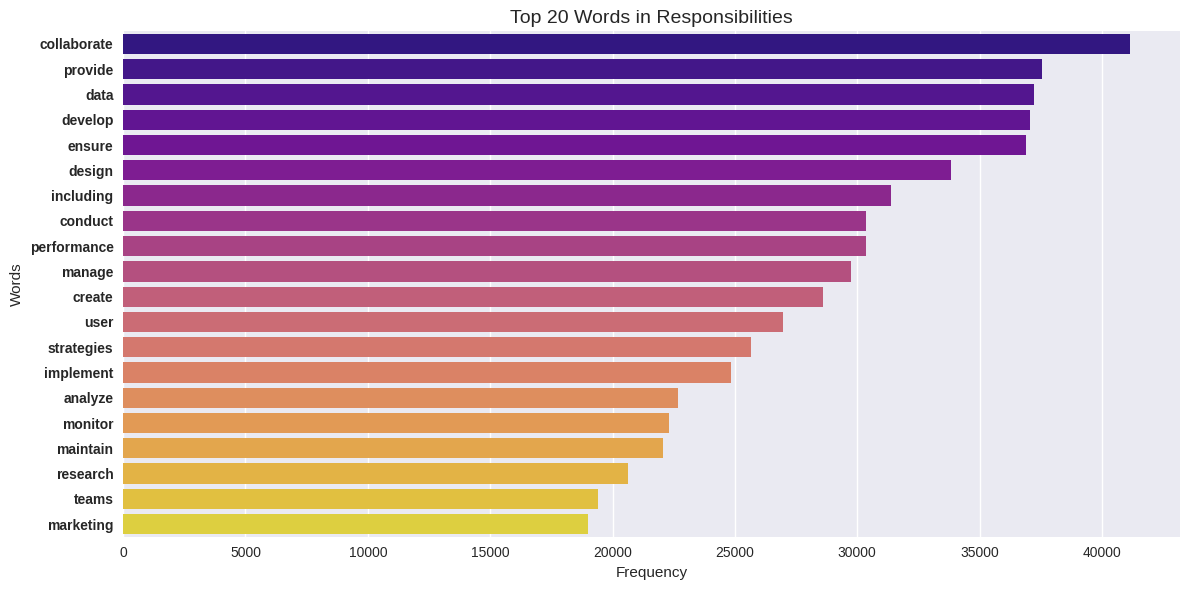
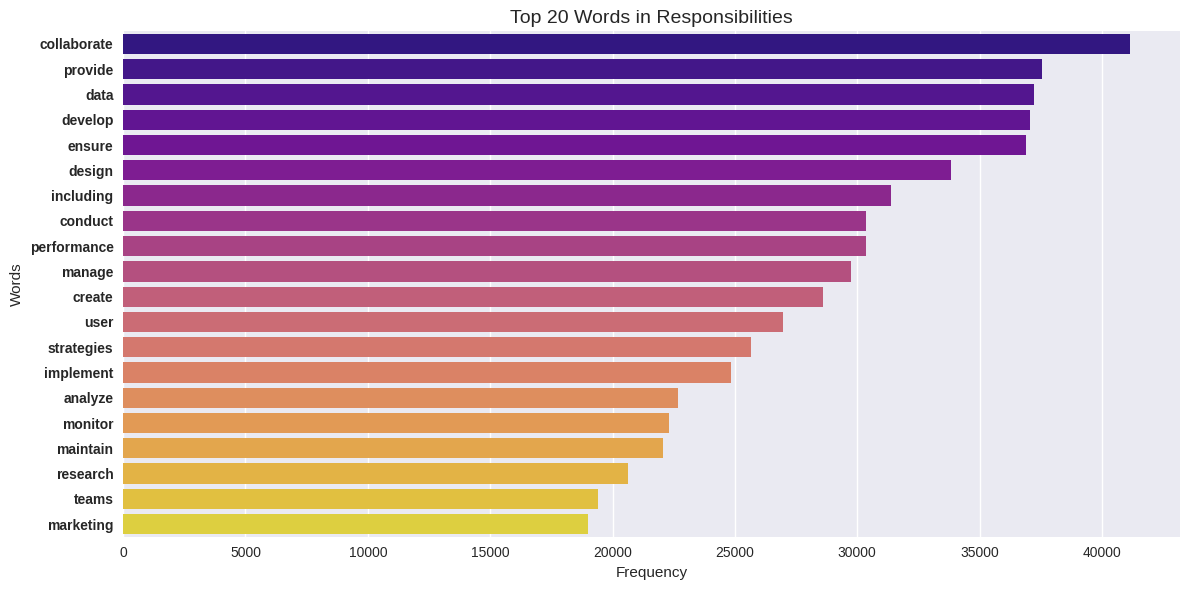
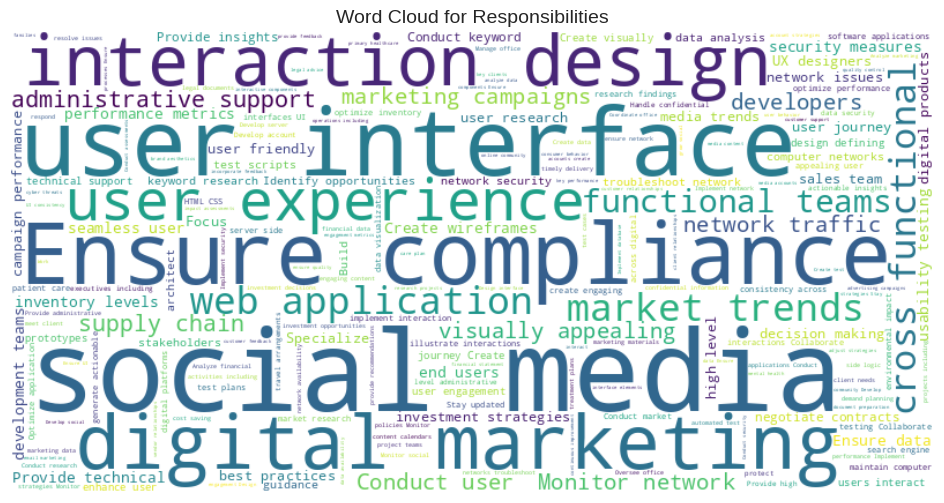
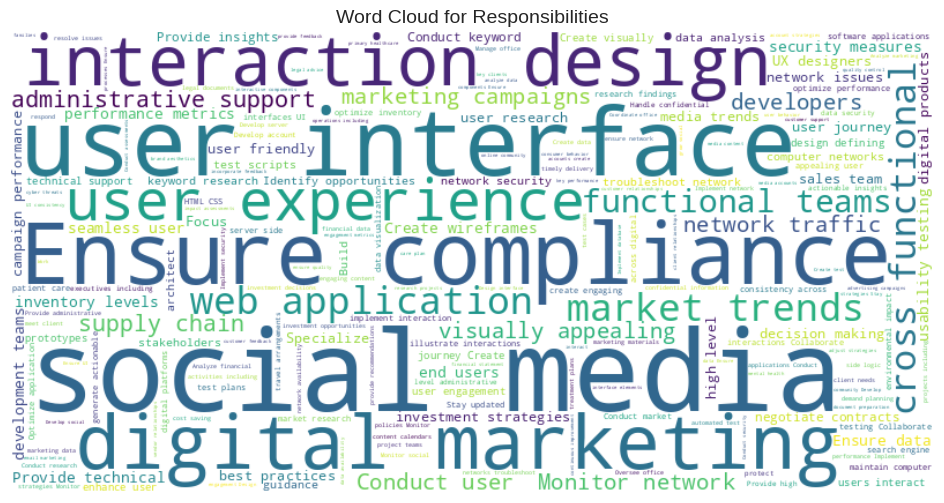

In [15]:
def display_visualizations(col, analysis):    
    # visualization figures
    fig1 = plot_top_words(analysis['top_words'], col)
    top_words_img = plot_to_html(fig1, filename=f"{col}_top_words.png")
    
    text = ' '.join(df[col].fillna('').astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    fig2 = plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {col}', fontsize=14)
    wordcloud_img = plot_to_html(fig2, filename=f"{col}_wordcloud.png")
    
    # HTML
    html = f"""
    <div style="font-family: Arial; margin: 20px 0;">
        <div style="display: flex; flex-wrap: wrap; gap: 20px;">
            <!-- Top Words Plot -->
            <div style="flex: 1; min-width: 300px; background: #2a2a2a; padding: 15px; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
                <h3 style="color: #FFFFFF; margin-top: 0;">📊 Top Words Frequency</h3>
                {top_words_img}
            </div>
            
            <!-- Word Cloud -->
            <div style="flex: 1; min-width: 300px; background: #2a2a2a; padding: 15px; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
                <h3 style="color: #FFFFFF; margin-top: 0;">☁️ Word Cloud</h3>
                {wordcloud_img}
            </div>
        </div>
    </div>
    """
    
    display(HTML(html))

# return figures
def plot_top_words(word_list, title):
    words, counts = zip(*word_list)
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words), palette='plasma', ax=ax)
    plt.title(f'Top {len(word_list)} Words in {title}', fontsize=14)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
    plt.tight_layout()
    return fig

# analysis loop:
for col in df.columns:
    if df[col].dtype in ['object', 'string']:
        avg_wc = df[col].dropna().astype(str).str.split().str.len().mean()
        if avg_wc >= 5:
            analysis = text_analyzer(df[col])
            display_column_analysis(col, analysis)
            display_visualizations(col, analysis)
        else:
            basic = label_style_analyzer(df[col])
            display_label_card(col, basic)

## 🌍 Geospatial Analysis


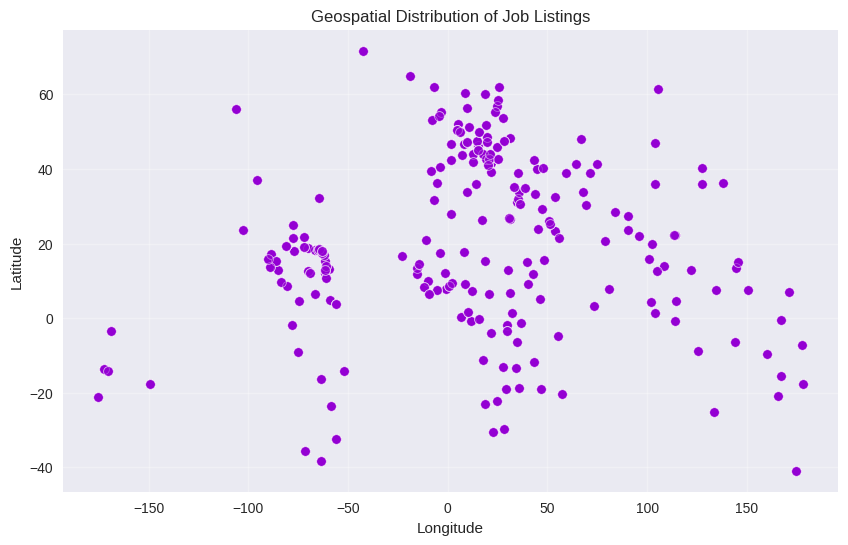
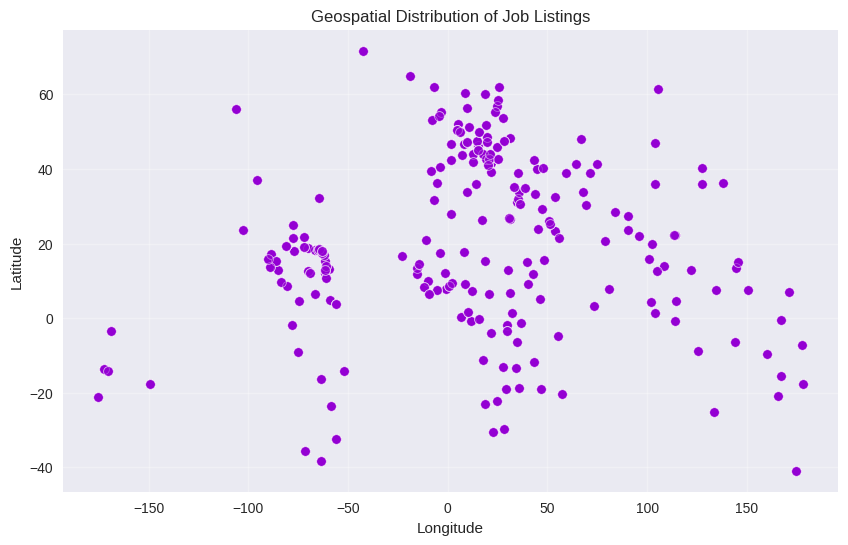
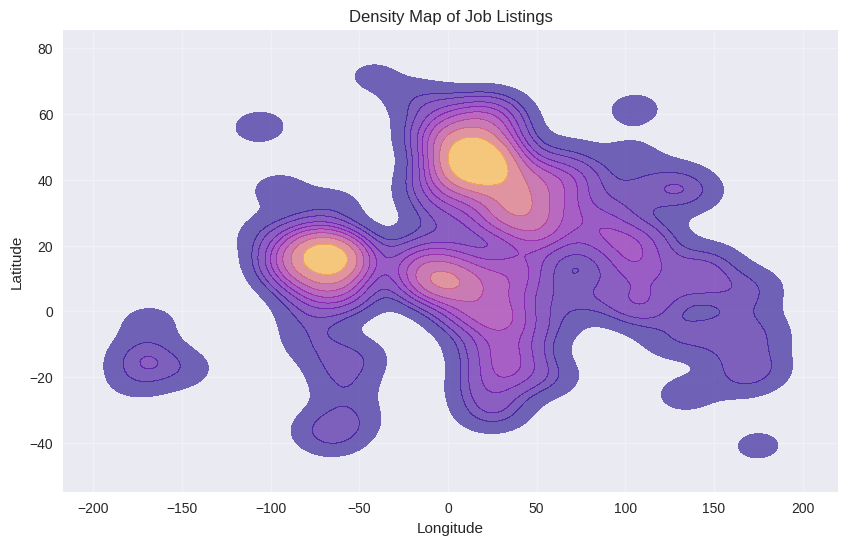
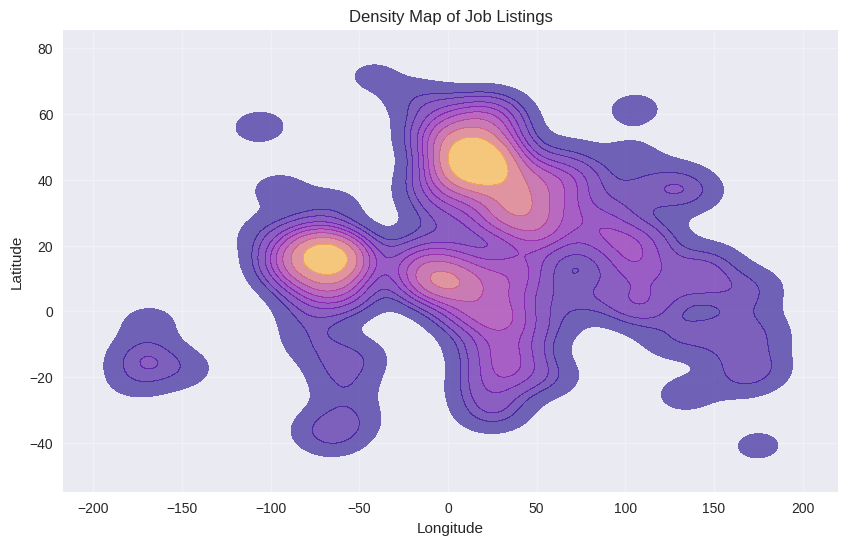

In [16]:
def plot_geospatial_card(df, lat_col='latitude', lon_col='longitude', sample_frac=0.2, max_points=17000):
    if lat_col not in df.columns or lon_col not in df.columns:
        display(HTML("<div style='color: orange;'>⚠️ Latitude and longitude columns not found.</div>"))
        return

    display(HTML("""
    <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
        <h2 style="color: white; font-weight: bold;">🌍 Geospatial Analysis</h2>
    </div>
    """))

    valid_coords = df[[lat_col, lon_col]].notnull().all(axis=1)
    valid_df = df[valid_coords].copy()
    valid_count = valid_coords.sum()
    percent = valid_coords.mean() * 100

    # stats card
    display(HTML(f"""
        <div style="background: #2a2a2a; padding: 15px; border-radius: 8px; font-family: Arial; margin-bottom: 20px;">
            <h3 style="color: #FFFFFF; font-weight: bold;">📍 Coordinate Summary</h3>
            <ul style="color: white; font-weight: bold;">
                <li>Total Rows with Valid Coordinates: {valid_count}</li>
                <li>Percent Valid: {percent:.1f}%</li>
            </ul>
        </div>
    """))

    # Limit points for faster plotting
    if len(valid_df) > max_points:
        valid_df = valid_df.sample(n=max_points, random_state=42)

    # Scatter plot
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    sns.scatterplot(data=valid_df, x=lon_col, y=lat_col, alpha=0.6, color="darkviolet", ax=ax1)
    ax1.set_title("Geospatial Distribution of Job Listings")
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.grid(True, alpha=0.3)
    scatter_img = plot_to_html(fig1, filename="scatter_map.png")

    # Density map (faster using fewer points)
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    sns.kdeplot(data=valid_df, x=lon_col, y=lat_col, fill=True, cmap='plasma', alpha=0.6, ax=ax2)
    ax2.set_title("Density Map of Job Listings")
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    ax2.grid(True, alpha=0.3)
    density_img = plot_to_html(fig2, filename="density_map.png")

    # Final layout
    html = f"""
    <div style="font-family: Arial; margin: 20px 0;">
        <div style="display: flex; flex-wrap: wrap; gap: 20px;">
            <div style="flex: 1; min-width: 300px; background: #2a2a2a; padding: 15px; border-radius: 8px;">
                <h3 style="color: #FFFFFF; font-weight: bold;">📌 Scatter Plot</h3>
                {scatter_img}
            </div>
            <div style="flex: 1; min-width: 300px; background: #2a2a2a; padding: 15px; border-radius: 8px;">
                <h3 style="color: #FFFFFF; font-weight: bold;">🔥 Density Plot</h3>
                {density_img}
            </div>
        </div>
    </div>
    """
    display(HTML(html))


plot_geospatial_card(df)

In [17]:
#@title Geographic Distribution (World Heatmap)
import pandas as pd
import plotly.express as px

# Assuming df is your DataFrame
country_counts = df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

fig = px.choropleth(country_counts, 
                    locations='Country',
                    locationmode='country names',
                    color='Count',
                    hover_name='Country',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Job Postings by Country')
fig.show()

In [18]:
def plot_geospatial_card(df, lat_col='latitude', lon_col='longitude', hover_col='Country', text_col='Job Title', sample_frac=0.2, max_points=17000, interactive=False):
    if lat_col not in df.columns or lon_col not in df.columns:
        display(HTML("<div style='color: orange;'>⚠️ Latitude and longitude columns not found.</div>"))
        return

    display(HTML("""
    <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
        <h2 style="color: white; font-weight: bold;">🌍 Geospatial Analysis</h2>
    </div>
    """))

    valid_coords = df[[lat_col, lon_col]].notnull().all(axis=1)
    valid_df = df[valid_coords].copy()
    valid_count = valid_coords.sum()
    percent = valid_coords.mean() * 100

    display(HTML(f"""
        <div style="background: #2a2a2a; padding: 15px; border-radius: 8px; font-family: Arial; margin-bottom: 20px;">
            <h3 style="color: #FFFFFF; font-weight: bold;">📍 Coordinate Summary</h3>
            <ul style="color: white; font-weight: bold;">
                <li>Total Rows with Valid Coordinates: {valid_count}</li>
                <li>Percent Valid: {percent:.1f}%</li>
            </ul>
        </div>
    """))

    if len(valid_df) > max_points:
        valid_df = valid_df.sample(n=max_points, random_state=42)
    
    if interactive:
        try:
            import plotly.express as px

            hover_name = hover_col if hover_col in valid_df.columns else None
            text = text_col if text_col in valid_df.columns else None
            
            fig = px.scatter_geo(valid_df,
                         lat=lat_col,
                         lon=lon_col,
                         hover_name=hover_name,
                         text=text,
                         scope='world',
                         title='🌍 Job Listings on the World Map',
                         opacity=0.6,
                         color_discrete_sequence=['darkviolet'])

            fig.update_traces(
            mode='markers',
            marker=dict(size=6),
            textfont=dict(size=10, color='darkgrey'),
            selector=dict(type='scattergeo')
            )
            
            fig.update_geos(
                showcountries=True,
                showland=True,
                landcolor="rgb(217, 217, 217)",
                showocean=True,
                oceancolor="lightblue"
            )

            fig.update_layout(
                title={
                    'text': '<b>🌍 Job Listings on the World Map</b>',
                    'y':0.95,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top',
                    'font': {'size': 20}
                },
                margin={"r":0,"t":80,"l":0,"b":0},
                hoverlabel=dict(
                    bgcolor="white",
                    font_size=12,
                    font_family="Arial"
                )
            )
            fig.show()
        except ImportError:
            display(HTML("<div style='color: orange;'>⚠️ Plotly not installed. Falling back to static plot.</div>"))
            interactive = False
    
    if not interactive:
        try:
            import cartopy.crs as ccrs
            import cartopy.feature as cfeature
            
            fig, ax = plt.subplots(figsize=(12, 8), 
                                 subplot_kw={'projection': ccrs.PlateCarree()})
            
            ax.add_feature(cfeature.LAND)
            ax.add_feature(cfeature.OCEAN)
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            
            hb = ax.hexbin(valid_df[lon_col], valid_df[lat_col], 
                          gridsize=50, cmap='plasma', 
                          mincnt=1, alpha=0.7)
            
            cb = fig.colorbar(hb, ax=ax, label='Density')
            
            ax.set_title('Global Density Distribution of Job Listings', pad=20)
            plt.tight_layout()
            
            density_img = plot_to_html(fig, filename="world_density_map.png")
            
            html = f"""
            <div style="font-family: Arial; margin: 20px 0;">
                <div style="flex: 1; min-width: 300px; background: #2a2a2a; padding: 15px; border-radius: 8px;">
                    <h3 style="color: #FFFFFF; font-weight: bold;">🌐 Global Density Map</h3>
                    {density_img}
                </div>
            </div>
            """
            display(HTML(html))
            
        except ImportError:
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.scatter(valid_df[lon_col], valid_df[lat_col], 
                       alpha=0.1, s=5, c='blue')
            ax.set_title('Geospatial Distribution of Job Listings')
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            ax.grid(True, alpha=0.3)
            
            density_img = plot_to_html(fig, filename="fallback_map.png")
            
            html = f"""
            <div style="font-family: Arial; margin: 20px 0;">
                <div style="flex: 1; min-width: 300px; background: #2a2a2a; padding: 15px; border-radius: 8px;">
                    <h3 style="color: #FFFFFF; font-weight: bold;">📍 Location Plot</h3>
                    {density_img}
                </div>
            </div>
            """
            display(HTML(html))

plot_geospatial_card(df, interactive=True)


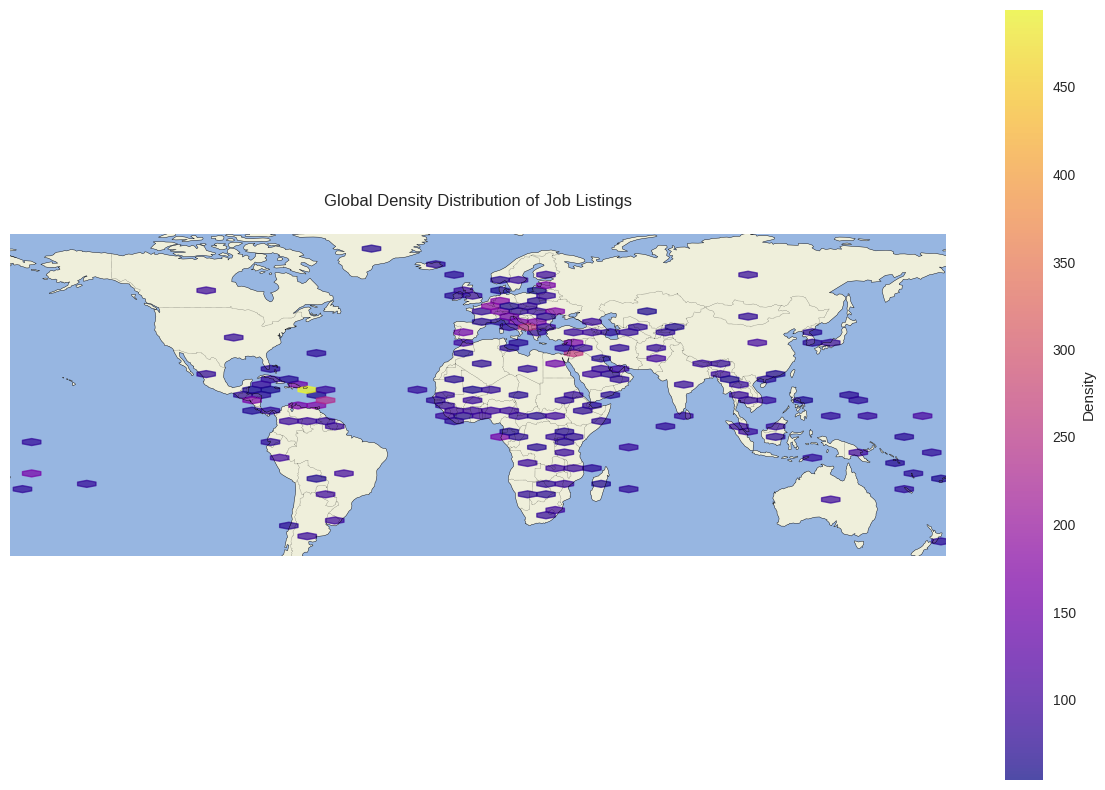
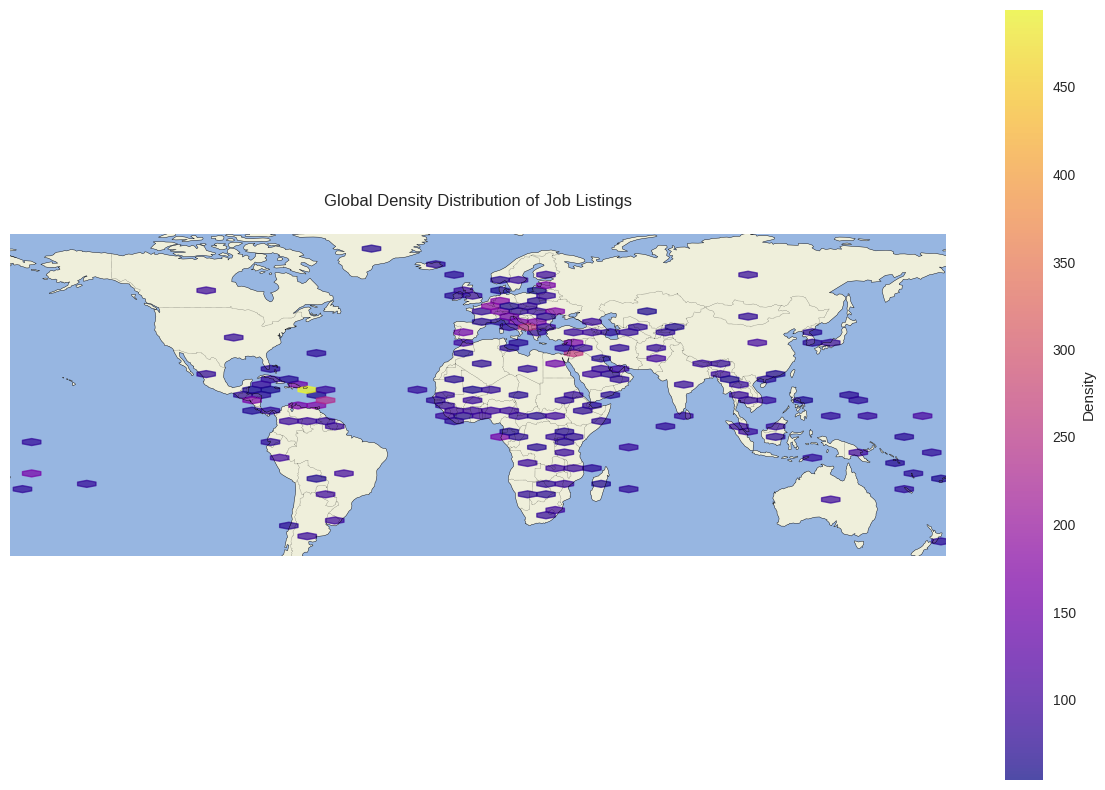

In [19]:
plot_geospatial_card(df, interactive=False)

## ⏳ Temporal Analysis


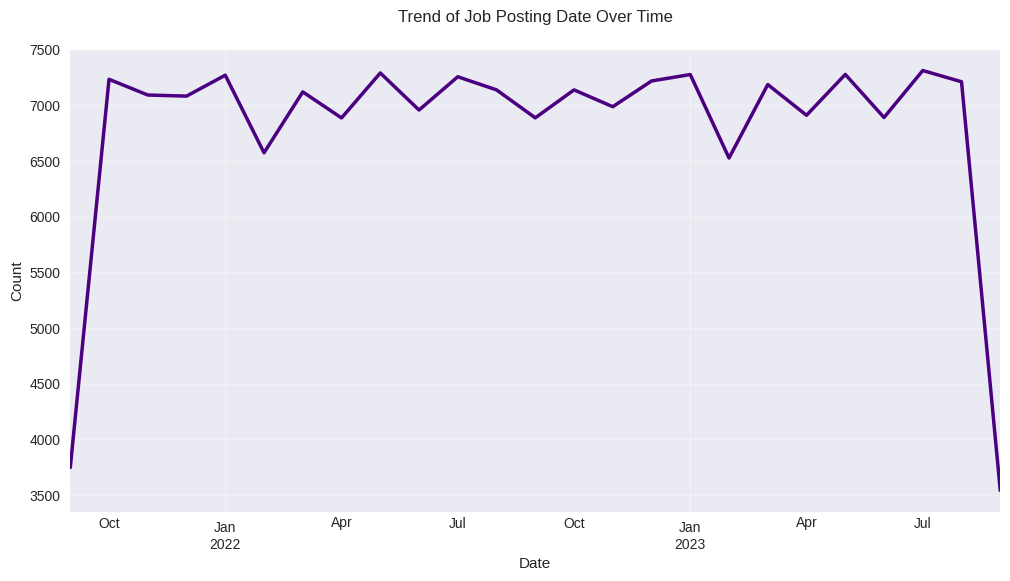
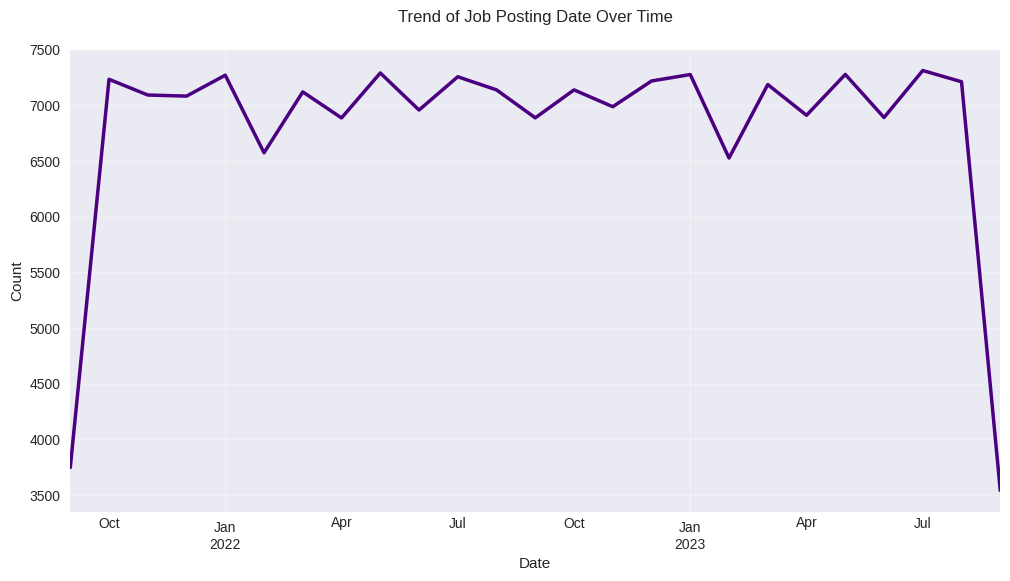

In [20]:
date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
if date_cols:
    display(HTML("""
    <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
        <h2 style="color: white; font-weight: bold;">⏳ Temporal Analysis</h2>
    </div>
    """))
    
    for col in date_cols:
        try:
            # Convert -> datetime (if not already)
            if not pd.api.types.is_datetime64_any_dtype(df[col]):
                df[col] = pd.to_datetime(df[col], errors='coerce')
            
            # summary stats
            min_date = df[col].min()
            max_date = df[col].max()
            time_span = max_date - min_date
            valid_count = df[col].notna().sum()
            null_count = df[col].isna().sum()
            
            # temporal plot
            plt.figure(figsize=(12, 6))
            monthly_counts = df[col].dt.to_period('M').value_counts().sort_index()
            monthly_counts.plot(kind='line', color='indigo', linewidth=2.5)
            plt.title(f'Trend of {col} Over Time', pad=20)
            plt.xlabel('Date')
            plt.ylabel('Count')
            plt.grid(True, alpha=0.3)
            
            # plot -> HTML
            plot_html = plot_to_html(plt.gcf(), filename=f"temporal_{col}.png")
            plt.close()
            
            # Create the HTML card
            display(HTML(f"""
            <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
                <h3 style="color: white; font-weight: bold;">📅 {col}</h3>
                
                <div style="display: flex; flex-wrap: wrap; gap: 20px; margin-bottom: 15px;">
                    <div style="flex: 1; min-width: 200px; background: #3a3a3a; padding: 10px; border-radius: 6px;">
                        <p style="color: #FFFFFF; margin: 5px 0;"><strong>Earliest Date:</strong> {min_date}</p>
                        <p style="color: #FFFFFF; margin: 5px 0;"><strong>Latest Date:</strong> {max_date}</p>
                    </div>
                    <div style="flex: 1; min-width: 200px; background: #3a3a3a; padding: 10px; border-radius: 6px;">
                        <p style="color: #FFFFFF; margin: 5px 0;"><strong>Time Span:</strong> {time_span}</p>
                        <p style="color: #FFFFFF; margin: 5px 0;"><strong>Valid Entries:</strong> {valid_count} ({null_count} nulls)</p>
                    </div>
                </div>
                
                {plot_html}
            </div>
            """))
            
        except Exception as e:
            display(HTML(f"""
            <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
                <h3 style="color: white; font-weight: bold;">⚠️ {col} Analysis Failed</h3>
                <p style="color: #FF9999;">Error: {str(e)}</p>
            </div>
            """))

## 💰 Salary Analysis


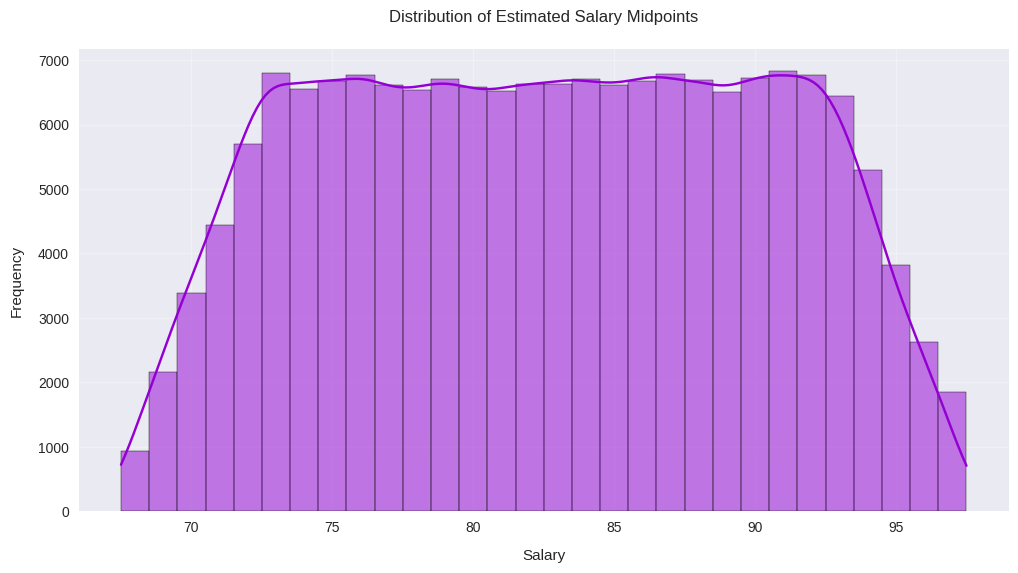
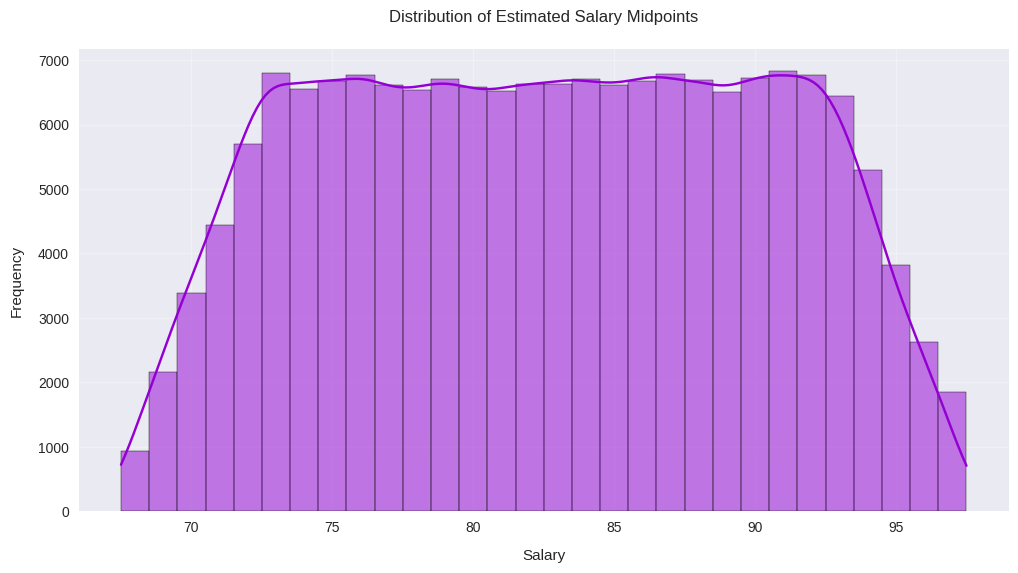


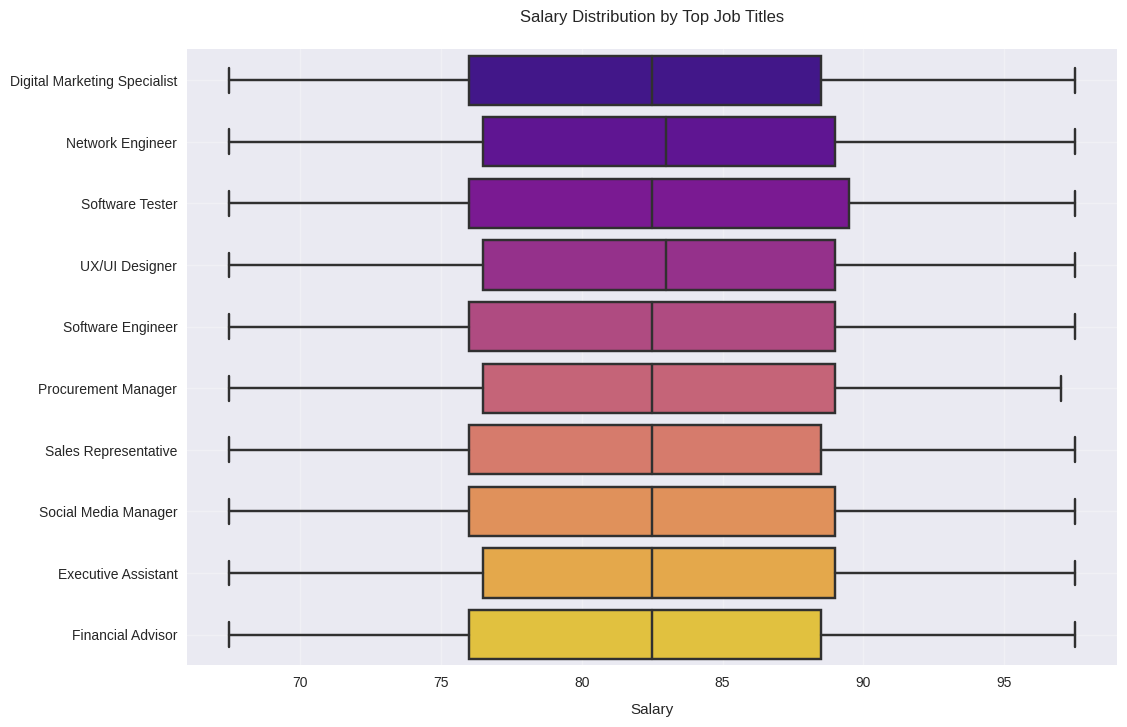
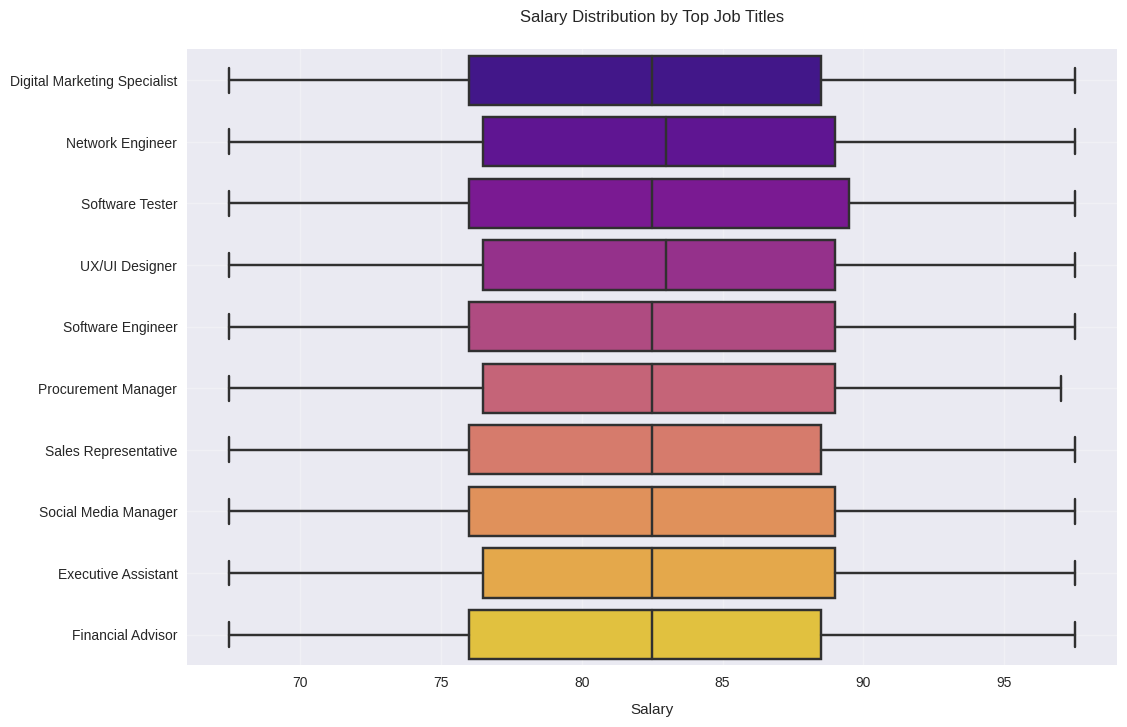

In [21]:
if 'Salary Range' in df.columns:
    display(HTML("""
    <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
        <h2 style="color: white; font-weight: bold;">💰 Salary Analysis By Thousands(K)</h2>
    </div>
    """))
    
    # Extracting numerical values from salary ranges
    def extract_salary(s):
        if pd.isna(s):
            return np.nan
        numbers = re.findall(r'\d{1,3}(?:,\d{3})*', str(s))
        if len(numbers) >= 2:
            return (float(numbers[0].replace(',', '')) + float(numbers[1].replace(',', ''))) / 2
        elif len(numbers) == 1:
            return float(numbers[0].replace(',', ''))
        else:
            return np.nan
    
    df['salary_midpoint'] = df['Salary Range'].apply(extract_salary)
    
    if not df['salary_midpoint'].isnull().all():
        # Salary Distribution Summary Card
        salary_stats = df['salary_midpoint'].describe(percentiles=[.1, .25, .5, .75, .9])
        salary_stats_html = pd.DataFrame(salary_stats).rename(columns={'salary_midpoint': 'Value'}).style \
            .format("{:,.0f}") \
            .set_properties(**{
                'background-color': '#3a3a3a',
                'color': 'white',
                'border-color': '#3a3a3a'
            }) \
            .set_table_styles([{
                'selector': 'th',
                'props': [('background-color', 'darkslateblue'), ('color', 'white')]
            }])
        
        display(HTML(f"""
        <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
            <h3 style="color: white; font-weight: bold;">📊 Salary Distribution Summary</h3>
            {salary_stats_html.to_html()}
        </div>
        """))
        
        # Salary Distribution Plot
        plt.figure(figsize=(12, 6))
        sns.histplot(df['salary_midpoint'].dropna(), bins=30, kde=True, color='darkviolet')
        plt.title('Distribution of Estimated Salary Midpoints', pad=20)
        plt.xlabel('Salary', labelpad=10)
        plt.ylabel('Frequency', labelpad=10)
        plt.grid(True, alpha=0.3)
        
        hist_img = plot_to_html(plt.gcf(), filename="salary_distribution.png")
        plt.close()
        
        display(HTML(f"""
        <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
            <h3 style="color: white; font-weight: bold;">📈 Salary Distribution</h3>
            {hist_img}
        </div>
        """))
        
        # Salary by Job Title
        if 'Job Title' in df.columns:
            top_jobs = df['Job Title'].value_counts().nlargest(10).index
            plt.figure(figsize=(12, 8))
            sns.boxplot(data=df[df['Job Title'].isin(top_jobs)], 
                       x='salary_midpoint', y='Job Title',
                       palette="plasma")
            plt.title('Salary Distribution by Top Job Titles', pad=20)
            plt.xlabel('Salary', labelpad=10)
            plt.ylabel('')
            plt.grid(True, alpha=0.3)
            
            boxplot_img = plot_to_html(plt.gcf(), filename="salary_by_title.png")
            plt.close()
            
            display(HTML(f"""
            <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
                <h3 style="color: white; font-weight: bold;">👔 Salary by Top Job Titles</h3>
                {boxplot_img}
            </div>
            """))
    else:
        display(HTML("""
        <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
            <h3 style="color: #FF9800; font-weight: bold;">⚠️ Salary Analysis Warning</h3>
            <p style="color: white;">Could not extract numerical salary values from the 'Salary Range' column.</p>
        </div>
        """))
    
    df = df.drop('salary_midpoint', axis=1)

## 🏢 Company Analysis


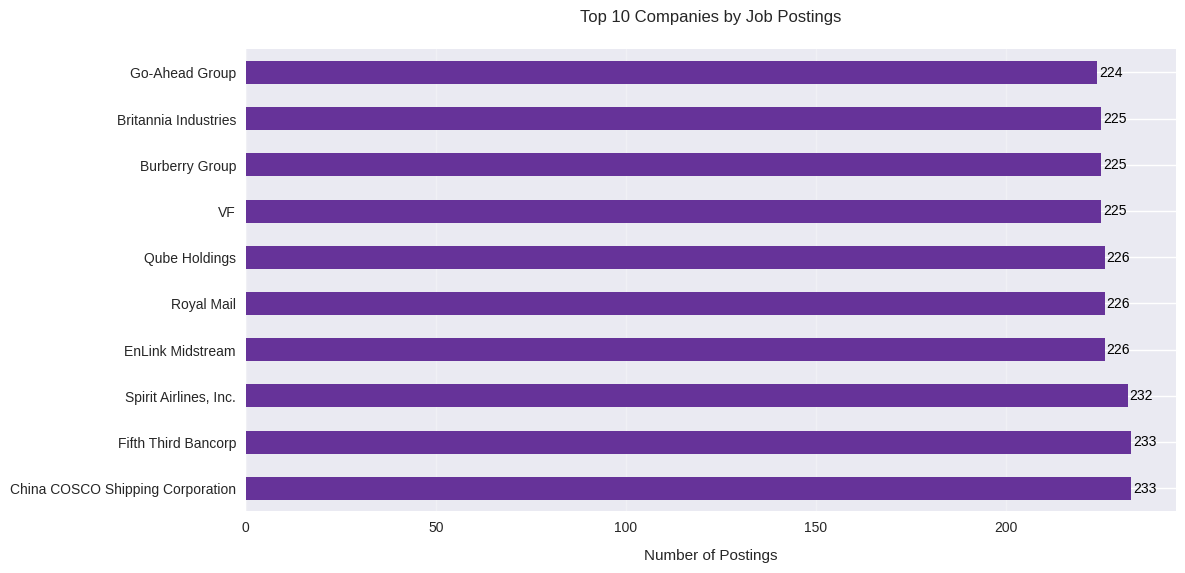
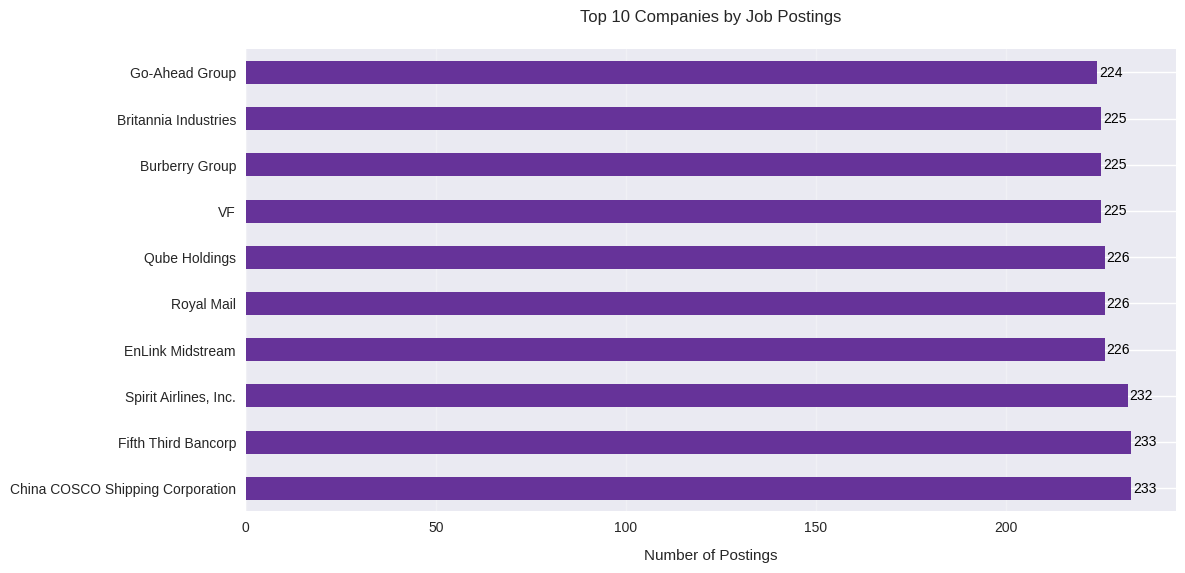


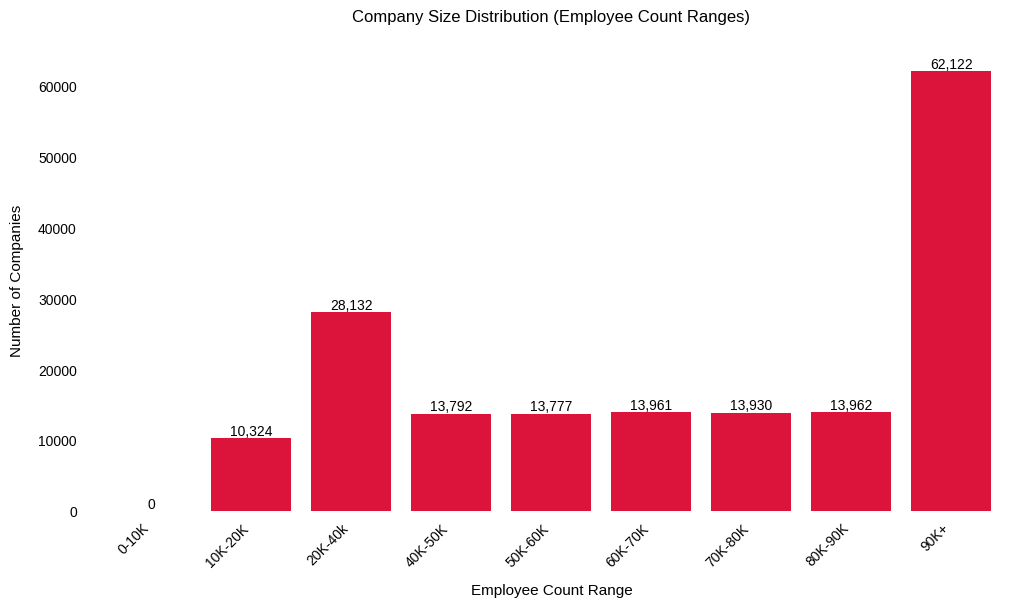
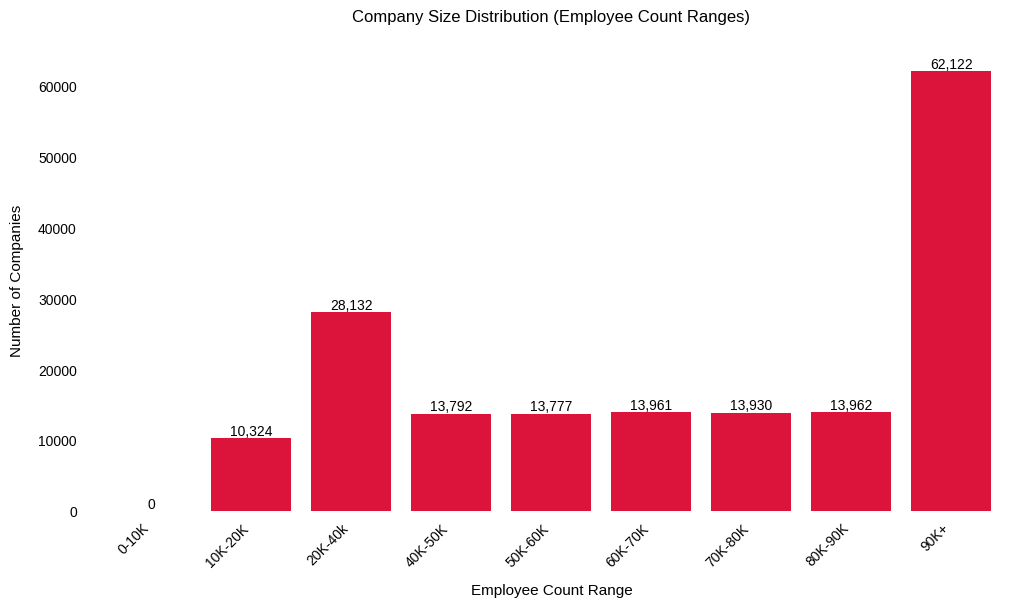

In [22]:
if 'Company' in df.columns:
    display(HTML("""
    <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
        <h2 style="color: white; font-weight: bold;">🏢 Company Analysis</h2>
    </div>
    """))
    
    # Top Companies
    top_companies = df['Company'].value_counts().nlargest(10)
    top_companies_html = top_companies.to_frame(name='Job Postings').style \
        .background_gradient(cmap='Blues') \
        .format('{:,}') \
        .set_properties(**{
            'background-color': '#3a3a3a',
            'color': 'white',
            'border-color': '#3a3a3a'
        }) \
        .set_table_styles([{
            'selector': 'th',
            'props': [('background-color', 'darkslateblue'), ('color', 'white')]
        }])
    
    display(HTML(f"""
    <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
        <h3 style="color: white; font-weight: bold;">🏆 Top Companies by Job Postings</h3>
        {top_companies_html.to_html()}
    </div>
    """))
    
    # Top Companies Visualization
    plt.figure(figsize=(12, 6))
    ax = top_companies.plot(kind='barh', color='rebeccapurple')
    plt.title('Top 10 Companies by Job Postings', pad=20)
    plt.xlabel('Number of Postings', labelpad=10)
    plt.ylabel('')
    plt.grid(True, axis='x', alpha=0.3)
    
    # value labels
    for i, v in enumerate(top_companies):
        ax.text(v + 0.5, i, f"{v:,}", color='black', va='center')
    
    companies_img = plot_to_html(plt.gcf(), filename="top_companies.png")
    plt.close()
    
    display(HTML(f"""
    <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
        <h3 style="color: white; font-weight: bold;">📊 Top Companies Visualization</h3>
        {companies_img}
    </div>
    """))
    
    # Company Size Analysis
    if 'Company Size' in df.columns:
        # Convert to string first to handle all cases
        size_series = df['Company Size'].astype(str)
        
        # binned histogram
        plt.figure(figsize=(12, 6))
        
        # Extract numerical values from strings (e.g., "100-500 employees" -> 100-500)
        extracted = size_series.str.extract(r'(\d+)[+-]?(\d+)?')
        df['size_numeric'] = extracted.apply(
            lambda x: (int(x[0]) + int(x[1]))/2 if pd.notna(x[1]) else int(x[0]) if pd.notna(x[0]) else None, 
            axis=1
        )
        
        if df['size_numeric'].notna().any():
            # Create logarithmic bins
            bins = [0, 10000, 20000, 40000, 50000, 60000, 70000, 80000, 90000, float('inf')]
            labels = [
                '0-10K', '10K-20K', '20K-40k', 
                '40K-50K', '50K-60K', '60K-70K', '70K-80K', '80K-90K', '90K+'
            ]
            
            # Bin
            df['size_binned'] = pd.cut(
                df['size_numeric'], 
                bins=bins, 
                labels=labels,
                right=False
            )
            
            # Plot
            ax = df['size_binned'].value_counts().sort_index().plot(
                kind='bar', 
                color='crimson',
                width=0.8
            )
            
            plt.title('Company Size Distribution (Employee Count Ranges)', pad=20)
            plt.xlabel('Employee Count Range', labelpad=10)
            plt.ylabel('Number of Companies', labelpad=10)
            plt.xticks(rotation=45, ha='right')
            plt.grid(True, axis='y', alpha=0.3)
            
            # value labels
            for p in ax.patches:
                ax.annotate(
                    f"{int(p.get_height()):,}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points',
                    color='black'
                )
        else:
            # -> categorical value counts IF no numerical values found
            size_counts = size_series.value_counts().nlargest(10)
            ax = size_counts.plot(kind='bar', color='crimson', width=0.8)
            plt.title('Top Company Size Categories', pad=20)
            plt.xlabel('Company Size', labelpad=10)
            plt.ylabel('Count', labelpad=10)
            plt.xticks(rotation=45, ha='right')
            plt.grid(True, axis='y', alpha=0.3)
            
            # value labels
            for p in ax.patches:
                ax.annotate(
                    f"{int(p.get_height()):,}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points',
                    color='black'
                )
        
        ax.set_facecolor('#FFFFFF')
        fig = plt.gcf()
        fig.patch.set_facecolor('white')
        ax.tick_params(colors='black')
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.title.set_color('black')
        
        size_img = plot_to_html(fig, filename="company_size_histogram.png")
        plt.close()
        
        # drop this temporary column
        df.drop(['size_numeric', 'size_binned'], axis=1, errors='ignore')
        
        display(HTML(f"""
        <div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
            <h3 style="color: white; font-weight: bold;">📏 Company Size Distribution</h3>
            {size_img}
        </div>
        """))

## 🎯 EDA Summary

In [23]:
display(HTML("""
<div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
    <h2 style="color: white; font-weight: bold;">🎯 EDA Summary</h2>
</div>
"""))

# Data Quality Summary
quality_summary = pd.DataFrame({
    'Metric': [
        'Total Rows', 
        'Total Columns',
        'Complete Rows (%)',
        'Duplicate Rows',
        'Text Columns',
        'Numerical Columns'
    ],
    'Value': [
        len(df),
        len(df.columns),
        (1 - df.isnull().any(axis=1).mean()) * 100,
        df.duplicated().sum(),
        len(TEXT_COLS),
        len(NUM_COLS)
    ]
})

# Format values
quality_summary['Display'] = quality_summary.apply(lambda x: 
    f"{x['Value']:,.0f}" if isinstance(x['Value'], (int, float)) and x['Metric'] not in ['Complete Rows (%)'] 
    else f"{x['Value']:.1f}%" if x['Metric'] == 'Complete Rows (%)' 
    else str(x['Value']),
    axis=1
)

quality_html = quality_summary[['Metric', 'Display']].style \
    .hide(axis='index') \
    .set_properties(**{
        'background-color': '#3a3a3a',
        'color': 'white',
        'border-color': '#3a3a3a'
    }) \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', 'darkslateblue'), ('color', 'white')]
    }]) \
    .to_html()

display(HTML(f"""
<div style="font-family: Arial; margin: 20px 0; background: #2a2a2a; padding: 15px; border-radius: 8px;">
    <h3 style="color: white; font-weight: bold;">🔍 Data Quality Summary</h3>
    {quality_html}
</div>
"""))